In [96]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
import seaborn as sns

from matplotlib.colors import LogNorm, Normalize
import astropy.units as u
from astropy.cosmology import Planck18, z_at_value
import pycbc.conversions as conv
from scipy.interpolate import CubicSpline

from matplotlib.ticker import AutoMinorLocator, LogLocator

from astropy.cosmology import Planck18 as cosmology


In [97]:
import matplotlib as mpl

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.size": 18
})



%config InlineBackend.figure_format='retina' # very useful command for high-res images

In [98]:
files = glob.glob1('powerlaw_smooth_hybrid_3G/', '*')
print(files)

df = pd.DataFrame()
for fi in files:
    df_temp = pd.read_csv('powerlaw_smooth_hybrid_3G/'+fi)
    df = pd.concat([df,df_temp])
# drop the zero rows that resulted from NoneType Networks
df = df.loc[~(df==0).all(axis=1)]

print(len(df[(df["hybr"]==0.0)]))

['hybr_0.9_0_20000.csv', 'hybr_0.95_60000_80000.csv', 'hybr_0.95_0_20000.csv', 'hybr_1.0_80000_100000.csv', 'hybr_0.0_0_20000.csv', 'hybr_0.95_80000_100000.csv', 'hybr_0.85_40000_60000.csv', 'hybr_0.85_0_20000.csv', 'hybr_0.5_0_20000.csv', 'hybr_0.97_20000_40000.csv', 'hybr_0.99_0_20000.csv', 'hybr_0.98_20000_40000.csv', 'hybr_0.9_20000_40000.csv', 'hybr_0.875_20000_40000.csv', 'hybr_0.925_80000_100000.csv', 'hybr_0.85_80000_100000.csv', 'hybr_0.8_80000_100000.csv', 'hybr_0.825_20000_40000.csv', 'hybr_0.85_60000_80000.csv', 'hybr_0.96_20000_40000.csv', 'hybr_0.8_20000_40000.csv', 'hybr_0.95_40000_60000.csv', 'hybr_1.0_20000_40000.csv', 'hybr_0.99_20000_40000.csv', 'hybr_0.925_20000_40000.csv', 'hybr_0.9_80000_100000.csv', 'hybr_0.0_20000_40000.csv', 'hybr_0.96_0_20000.csv', 'hybr_0.825_0_20000.csv', 'hybr_0.98_40000_60000.csv', 'hybr_0.875_40000_60000.csv', 'hybr_0.97_80000_100000.csv', 'hybr_0.925_60000_80000.csv', 'hybr_0.9_40000_60000.csv', 'hybr_0.925_0_20000.csv', 'hybr_0.0_60000_

In [ ]:
df.columns

Index(['index', 'Mc', 'eta', 'chi1x', 'chi2x', 'chi1y', 'chi2y', 'chi1z',
       'chi2z', 'DL', 'tc', 'phic', 'iota', 'ra', 'dec', 'psi', 'gmst0',
       'hybr', 'Mc_err', 'eta_err', 'DL_err', 'chi1z_err', 'chi2z_err',
       'iota_err', 'ra_err', 'dec_err', 'psi_err', 'Mc_bias', 'eta_bias',
       'DL_bias', 'chi1z_bias', 'chi2z_bias', 'iota_bias', 'ra_bias',
       'dec_bias', 'psi_bias', 'snr', 'faith', 'inner_prod', 'z', 'z_err',
       'z_bias', 'm1_src', 'm2_src', 'm1_src_err', 'm2_src_err', 'm1_src_bias',
       'm2_src_bias', 'm1_det', 'm2_det', 'm1_det_err', 'm2_det_err',
       'm1_det_bias', 'm2_det_bias', 'q', 'q_err', 'q_bias'],
      dtype='object')

In [ ]:
print("Median SNR:", np.median(df[(df["hybr"]==0.0)]["snr"]))

print(">0:", np.sum((df["hybr"]==0.0) & (df["snr"]>0)))
print(">10:", np.sum((df["hybr"]==0.0) & (df["snr"]>10)))
print(">50:", np.sum((df["hybr"]==0.0) & (df["snr"]>50)))
print(">100:", np.sum((df["hybr"]==0.0) & (df["snr"]>100)))
print(">200:", np.sum((df["hybr"]==0.0) & (df["snr"]>200)))
print(">300:", np.sum((df["hybr"]==0.0) & (df["snr"]>300)))

Median SNR: 22.15427743203597
>0: 100000
>10: 88693
>50: 12559
>100: 3068
>200: 924
>300: 514


## Set the $\chi_{1,2}$ biases to their max allowed value

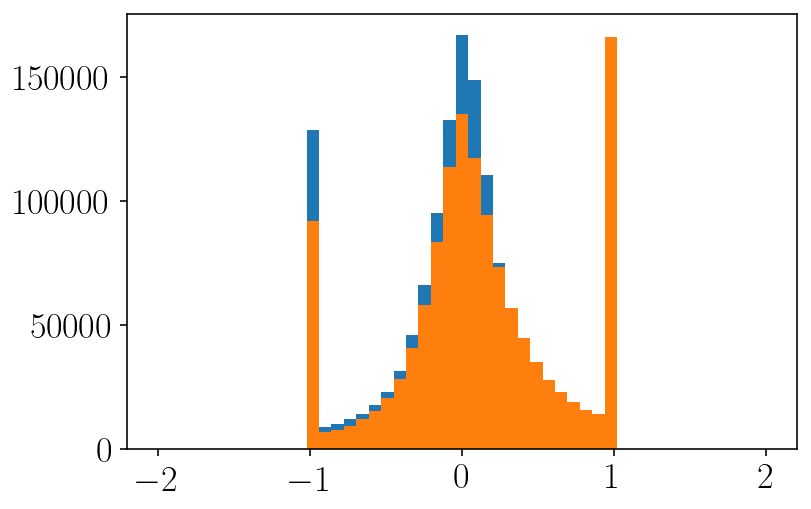

In [ ]:
mask = (np.abs(df["chi1z"]+ df["chi1z_bias"]) > 1.0)
df.loc[(np.abs(df["chi1z"]+ df["chi1z_bias"]) > 1.0), "chi1z_bias"] = np.sign(df[mask]["chi1z_bias"]) - df[mask]["chi1z"]

mask = (np.abs(df["chi2z"]+ df["chi2z_bias"]) > 1.0)
df.loc[(np.abs(df["chi2z"]+ df["chi2z_bias"]) > 1.0), "chi2z_bias"] = np.sign(df[mask]["chi2z_bias"]) - df[mask]["chi2z"]

plt.hist(df["chi1z_bias"] + df["chi1z"], bins=np.linspace(-2.0, 2.0, 50));
plt.hist(df["chi2z_bias"] + df["chi2z"], bins=np.linspace(-2.0, 2.0, 50));

# Compute M_tot

In [ ]:
df["m_tot"] = df["m1_src"] + df["m2_src"]
df["m_tot_bias"] = df["m1_src_bias"] + df["m2_src_bias"]
df["m_tot_err"] = np.sqrt(df["m1_src_err"]**2 + df["m2_src_err"]**2)

In [ ]:
data = df[(df["hybr"]==0.85) & (df["snr"]>100)]

# plt.scatter(data["snr"], np.abs(data["m_tot_bias"])/data["m_tot_err"], s=4)
# plt.scatter(data["snr"], np.abs(data["m1_src_bias"])/data["m1_src_err"], s=4)
# plt.scatter(data["snr"], np.abs(data["m2_src_bias"])/data["m2_src_err"], s=4)

# # plt.ylim(0, 100)
# plt.show()

print(np.median(np.abs(data["m_tot_bias"])/data["m_tot_err"]))
print(np.median(np.abs(data["m1_src_bias"])/data["m1_src_err"]))
print(np.median(np.abs(data["m2_src_bias"])/data["m2_src_err"]))
print()
print(np.median(np.abs(data["m_tot_bias"])))
print(np.median(np.abs(data["m1_src_bias"])))
print(np.median(np.abs(data["m2_src_bias"])))

print()
print(np.median(np.abs(data["m_tot_err"])))
print(np.median(np.abs(data["m1_src_err"])))
print(np.median(np.abs(data["m2_src_err"])))


0.5356458622262057
0.8608348165136752
1.1934352418729106

1.0087068955529608
1.229175988433998
1.385880782046344

1.8590633694870082
1.528798246116764
1.0400917863580696


# Compute $\chi_{eff}$

In [ ]:
def chi_eff_from_df(df):
    chi1 = df["chi1z"]
    chi2 = df["chi2z"]
    m1 = df["m1_det"]
    m2 = df["m2_det"]

    chi_eff = (1/(m1+m2)) * (m1*chi1 + m2*chi2)

    chi1_biased = chi1 + df["chi1z_bias"]
    chi2_biased = chi2 + df["chi2z_bias"]
    m1_biased = m1 + df["m1_det_bias"]
    m2_biased = m2 + df["m2_det_bias"]

    chi_eff_biased = (1/(m1_biased+m2_biased)) * (m1_biased*chi1_biased + m2_biased*chi2_biased)
    chi_eff_bias = chi_eff_biased - chi_eff


    sigchi1 = df["chi1z_err"]
    sigchi2 = df["chi2z_err"]
    sigm1 = df["m1_det_err"]
    sigm2 = df["m2_det_err"]

    aux0=((((chi1-chi2)**2))*((m2**2)*(sigm1**2)))+((((chi1-chi2)**2))*((m1**2)*(sigm2**2)))
    aux1=((m1**2)*((((m1+m2)**2))*(sigchi1**2)))+(((m2**2)*((((m1+m2)**2))*(sigchi2**2)))+aux0)

    chi_eff_err = np.sqrt((((m1+m2)**-4.)*aux1))

    return chi_eff, chi_eff_bias, chi_eff_err


def chi_eff_src_from_df(df):
    chi1 = df["chi1z"]
    chi2 = df["chi2z"]
    m1 = df["m1_src"]
    m2 = df["m2_src"]

    chi_eff = (1/(m1+m2)) * (m1*chi1 + m2*chi2)

    chi1_biased = chi1 + df["chi1z_bias"]
    chi2_biased = chi2 + df["chi2z_bias"]
    
    m1_biased = m1 + df["m1_src_bias"]
    m2_biased = m2 + df["m2_src_bias"]

    chi_eff_biased = (1/(m1_biased+m2_biased)) * (m1_biased*chi1_biased + m2_biased*chi2_biased)
    chi_eff_bias = chi_eff_biased - chi_eff


    sigchi1 = df["chi1z_err"]
    sigchi2 = df["chi2z_err"]
    sigm1 = df["m1_src_err"]
    sigm2 = df["m2_src_err"]

    aux0=((((chi1-chi2)**2))*((m2**2)*(sigm1**2)))+((((chi1-chi2)**2))*((m1**2)*(sigm2**2)))
    aux1=((m1**2)*((((m1+m2)**2))*(sigchi1**2)))+(((m2**2)*((((m1+m2)**2))*(sigchi2**2)))+aux0)

    chi_eff_err = np.sqrt((((m1+m2)**-4.)*aux1))

    return chi_eff, chi_eff_bias, chi_eff_err

In [ ]:
df["chi_eff"], df["chi_eff_bias"], df["chi_eff_err"] = chi_eff_src_from_df(df)
df = df.dropna()

# Population Distribution

In [ ]:
from scipy import interpolate, integrate

def power(m1, alpha, m_min, m_max):
    '''
    BBH merger primary mass PDF.
    '''
    if alpha != -1:
        N1 = 1 / ((m_max**(alpha+1) - m_min**(alpha+1))/(alpha+1))
    else:
        N1 = 1/(np.log(m_max/m_min))

    return np.piecewise(m1, [(m1 < m_min), (m1 >= m_min)*(m1 < m_max), (m1 >= m_max)],
                        [0, lambda m1: N1*m1**alpha, 0])

def butterworth(m1, m0, eta):
    norm = integrate.trapezoid((1+ (m0/m1)**eta)**(-1), m1)

    return (1+ (m0/m1)**eta)**(-1) / norm

def truncation(m1, m_min, m_max):
    return np.piecewise(m1, [(m1 < m_max), (m1 >= m_min)*(m1 < m_max), (m1 >= m_max)],
                        [0, 1.0, 0])

def beta(chi, a, b):
    func = chi**(a-1) * (1-chi)**(b-1)
    norm = integrate.trapezoid(func, chi)
    return func/norm

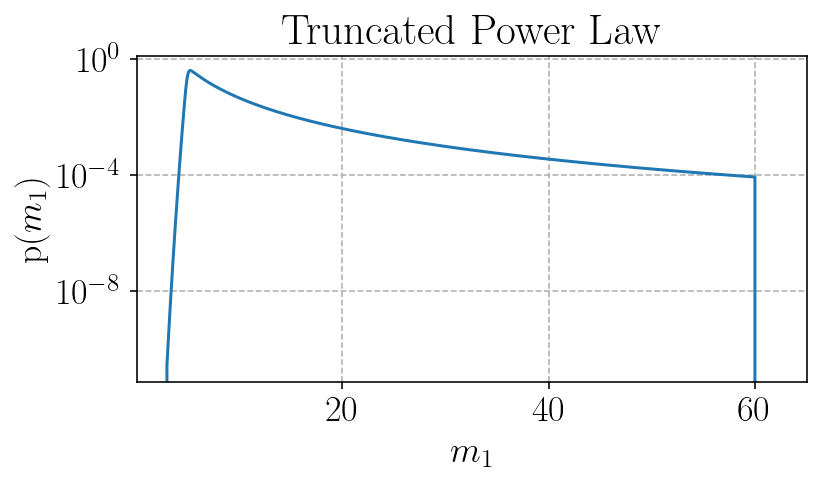

In [ ]:
# Mass Distribution
fig, ax = plt.subplots(figsize=(6,3))

bins = np.geomspace(2, 100, 100)

# plt.hist(df["m1_src"], bins=bins, histtype='step', density=True)

m1 = np.geomspace(2, 100, 100000)
pdf_m1 = butterworth(m1, 5, 50) * power(m1, -3.5, 3, 60)
pdf_m1 = pdf_m1/integrate.trapezoid(pdf_m1, m1)
plt.plot(m1, pdf_m1)

plt.xlim(0.1, 65)

plt.xlabel("$m_1$")
plt.ylabel("p($m_1$)")
# plt.legend(loc='upper right')
plt.title("Truncated Power Law", variant='small-caps')

plt.semilogy()

plt.grid(ls='--')

plt.show()

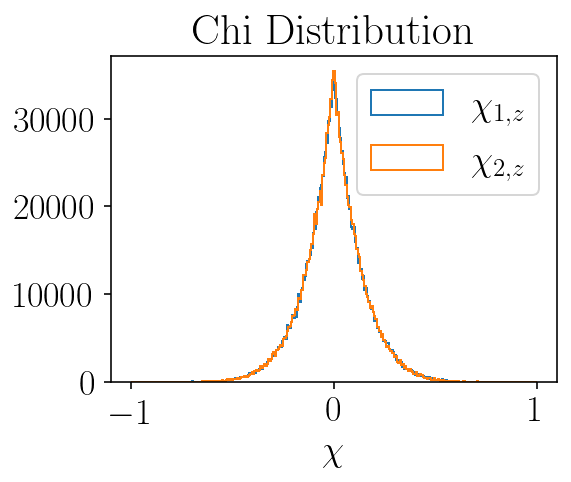

In [ ]:
# Chi Distribution
fig, ax = plt.subplots(figsize=(4, 3))

chi_range = np.linspace(0, 1, 100000)
a = 2
b = 7
pdf_chi = beta(chi_range, a, b)
# plt.plot(chi_range, pdf_chi)

bins = np.linspace(-1, 1, 300)
plt.hist(df["chi1z"], bins=bins, histtype='step', label="$\chi_{1,z}$")
plt.hist(df["chi2z"], bins=bins, histtype='step', label="$\chi_{2,z}$")

# plt.xlim(0, 1)
plt.xlabel("$\chi$")
plt.ylabel("")
plt.legend(loc='upper right')
plt.title("Chi Distribution")

plt.show()

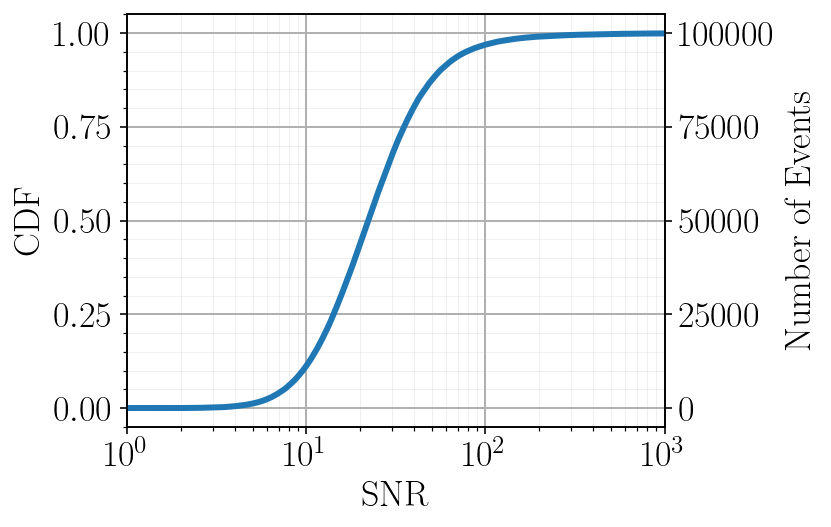

In [ ]:
# SNR Distribution
fig, ax = plt.subplots(figsize=(6,4))

data = df[df["hybr"]==0]["snr"]

bins = np.geomspace(0.1, 5000, 300)
# plt.hist(data, bins=bins, histtype='step')

count, bins_count = np.histogram(data, bins=bins)
pdf = count / sum(count)
cdf = np.cumsum(pdf)
ax.plot(bins_count[1:], cdf)
ax.set_ylabel("CDF")
ax.set_xlabel("SNR")

ax.grid(which = "major", linewidth = 1)
ax.grid(which = "minor", linewidth = 0.5, alpha=0.2)
ax.minorticks_on()

ax2 = ax.twinx()
count, bins_count = np.histogram(data, bins=bins)
pdf = count
cdf = np.cumsum(pdf)
ax2.plot(bins_count[1:], cdf, lw=3)
ax2.set_ylabel("Number of Events")


plt.xlim(1, 1000)
plt.xlabel("SNR")
plt.semilogx()
plt.tick_params(axis='y', which='minor')

plt.tight_layout()
# plt.savefig("1D_bias_plots/snr_cdf.pdf", dpi=300)
plt.show()

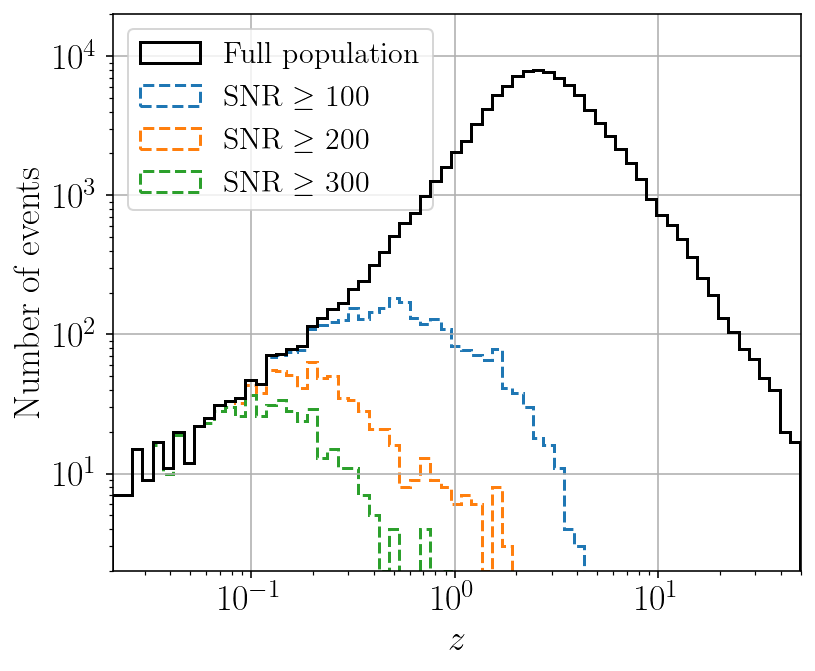

In [ ]:
snrs = [100, 200, 300]

fig, ax = plt.subplots(figsize=(6,5))


data = df[(df["hybr"]==0.0) & (df["snr"]>0)]
bins = np.geomspace(0.001, 100, 100)
# bins = np.linspace(0, 10, 1000)

plt.hist(data["z"], bins=bins, label="Full population", color='k', lw=1.5, histtype='step', zorder=20)

for snr in snrs:
    data = df[(df["hybr"]==0.0) & (df["snr"]>snr)]
    bins = np.geomspace(0.001, 100, 100)
    plt.hist(data["z"], bins=bins, label=f"SNR $\geq$ {snr}", lw=1.5, ls='--', histtype='step')

plt.loglog()
plt.xlim(0.021, 50)
plt.ylim(2, 2e4)
plt.legend(fontsize=15, loc='upper left')
plt.grid()

plt.xlabel("$z$")
plt.ylabel("Number of events")

plt.tight_layout()
# plt.savefig('1D_bias_plots/snr_vs_z_dist.pdf', dpi=300)
plt.show()

## Explaining the positive DL, z biases

Usman+ 2019 (https://iopscience.iop.org/article/10.3847/1538-4357/ab0b3e) study the correlation between DL and inclination posteriors. They explain first that for most ~face-on and face-away binaries, there is a strong degeneracy between the DL and inclination measurements due to how the two dependancies show up in the GW amplitude terms.

In Fig. 8, they show the posteriors for ET with an injection of i=~60, where we can see that there is a strong support for larger DL values. Most of our binaries have i~$\pi/2$, which corresponds to this region vaguely. Hence, the Fisher analysis prefers a positive DL bias.

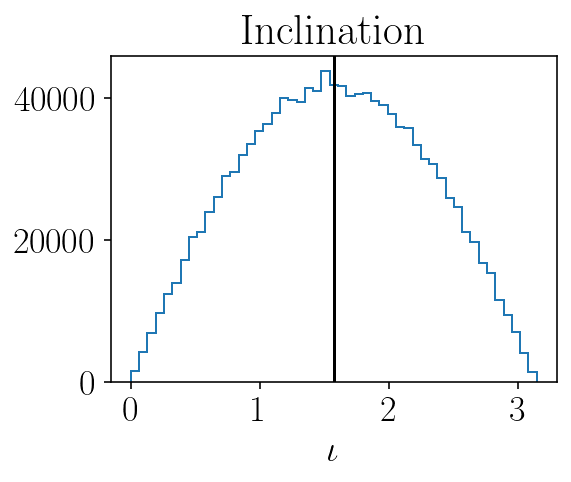

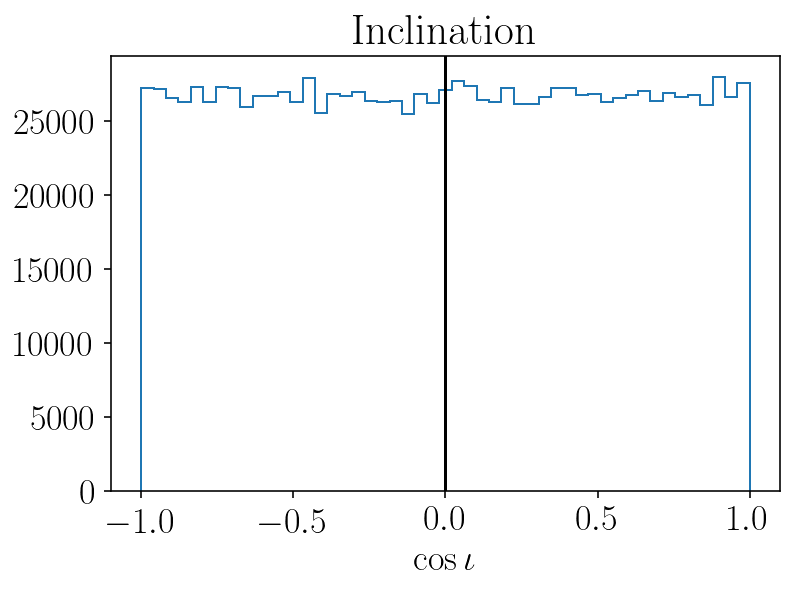

In [ ]:
fig, ax = plt.subplots(figsize=(4, 3))

bins = np.linspace(0, np.pi, 50)
plt.hist(df["iota"], bins=bins, histtype='step')
plt.axvline(np.pi/2, color='k')

# plt.xlim(0, 1)
plt.xlabel("$\iota$")
plt.ylabel("")
plt.title("Inclination")

plt.show()

bins = np.linspace(-1, 1, 50)
plt.hist(np.cos(df["iota"]), bins=bins, histtype='step')
plt.axvline(0.0, color='k')

# plt.xlim(0, 1)
plt.xlabel("$\cos \iota$")
plt.ylabel("")
plt.title("Inclination")

plt.show()

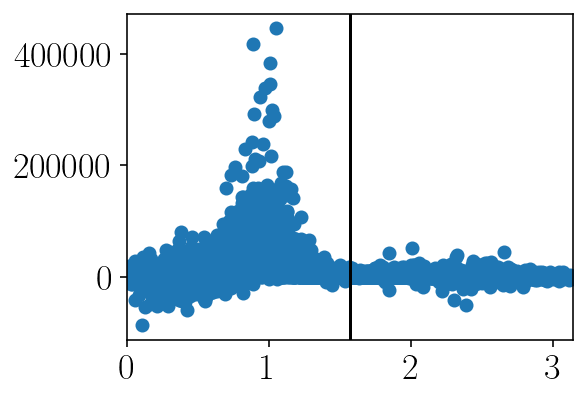

In [ ]:
fig, ax = plt.subplots(figsize=(4, 3))

data = df[(df["hybr"]==0.9) & (df["snr"]>12)]
plt.scatter(data["iota"], data["DL_bias"])
plt.axvline(np.pi/2, color='k')
plt.xlim(0, np.pi)
# plt.semilogy()
plt.show()

# Comparisons to other work

## Listening to the Universe SNR comparison

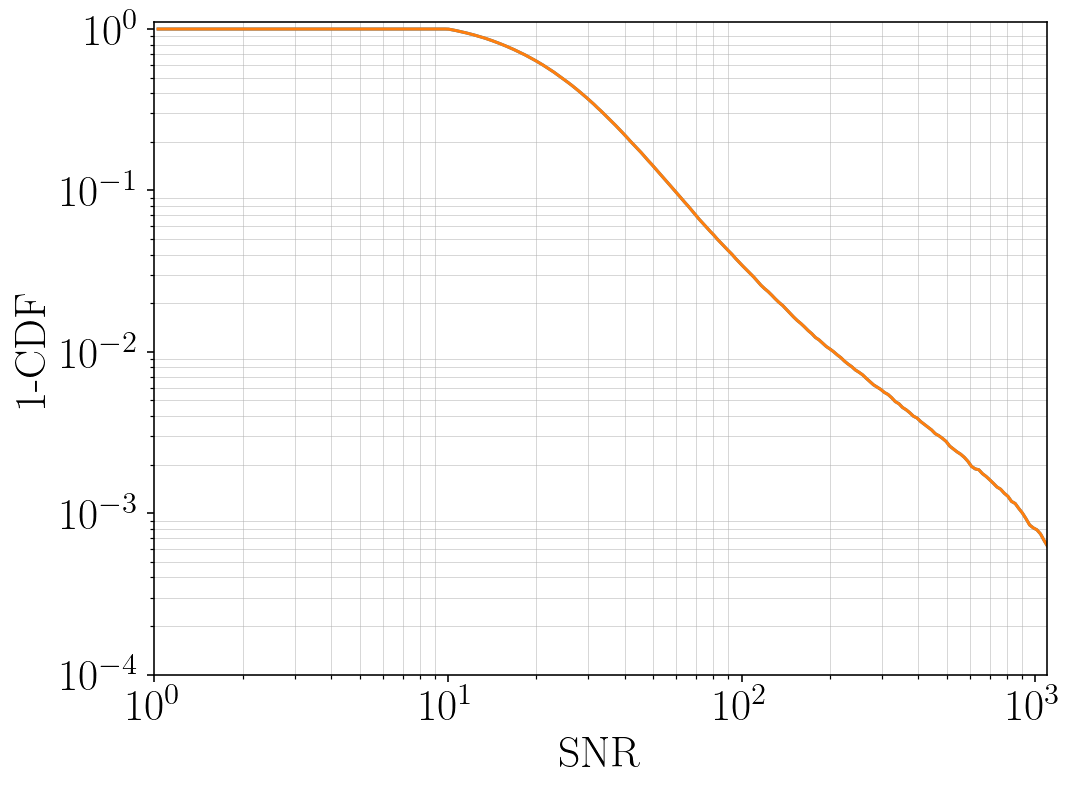

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))

bins = np.geomspace(1, 5000, 300)

data = df[(df["hybr"]==0.0) & (df["snr"]>10)]["snr"]
count, bins_count = np.histogram(data, bins=bins)
pdf = count / sum(count)
cdf = np.cumsum(pdf)
ax.plot(bins_count[1:], 1-cdf)

data = df[(df["hybr"]==0.0) & (df["snr"]>10) & (np.abs(df["chi1z"])<0.75) & (np.abs(df["chi2z"])<0.75)]["snr"]
count, bins_count = np.histogram(data, bins=bins)
pdf = count / sum(count)
cdf = np.cumsum(pdf)
ax.plot(bins_count[1:], 1-cdf)

ax.set_ylabel("1-CDF")
ax.set_xlabel("SNR")

ax.grid(which = "major", linewidth = 1)
ax.grid(which = "minor", linewidth = 0.5, alpha=0.5)
ax.minorticks_on()

ax.set_ylim(1e-4, 1.1)
ax.set_xlim(1, 1.1e3)
plt.loglog()
plt.grid()
plt.show()

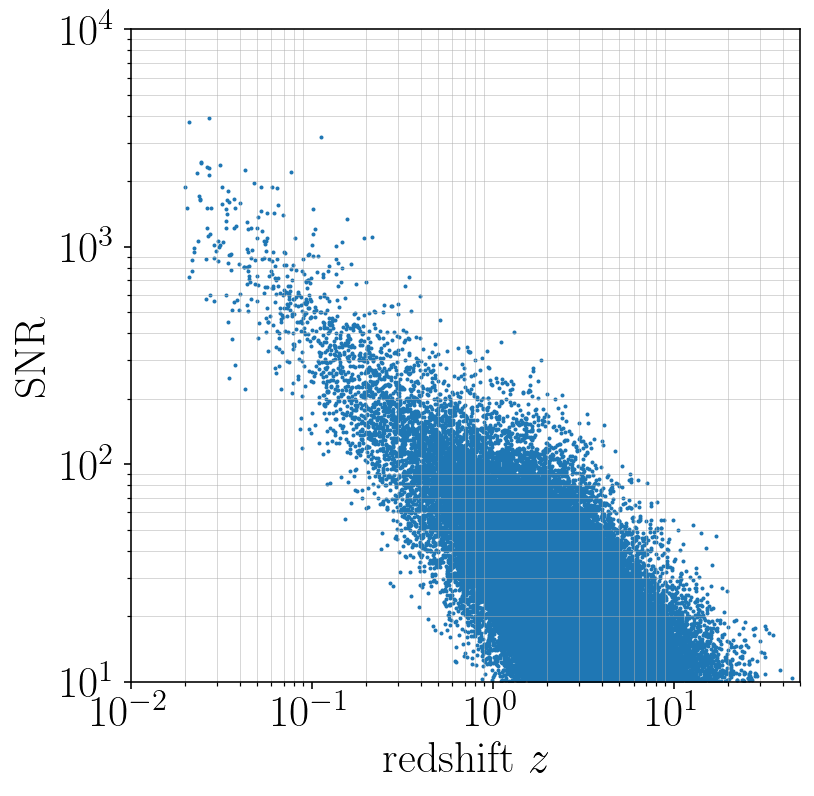

In [ ]:
# compare to Fig. 5 of Listening to the Universe
# They clearly have more low redshift binaries, probably due to delay times

fig, ax = plt.subplots(figsize=(6,6))

data = df[(df["hybr"]==0.0) & (df["snr"]>10)]

plt.scatter(data["z"], data["snr"], s=1)

ax.grid(which = "minor", linewidth = 0.5, alpha=0.5)
ax.minorticks_on()

plt.xlabel("redshift $z$")
plt.ylabel("SNR")

plt.xlim(1e-2, 5e1)
plt.ylim(10, 1e4)

plt.loglog()

plt.show()

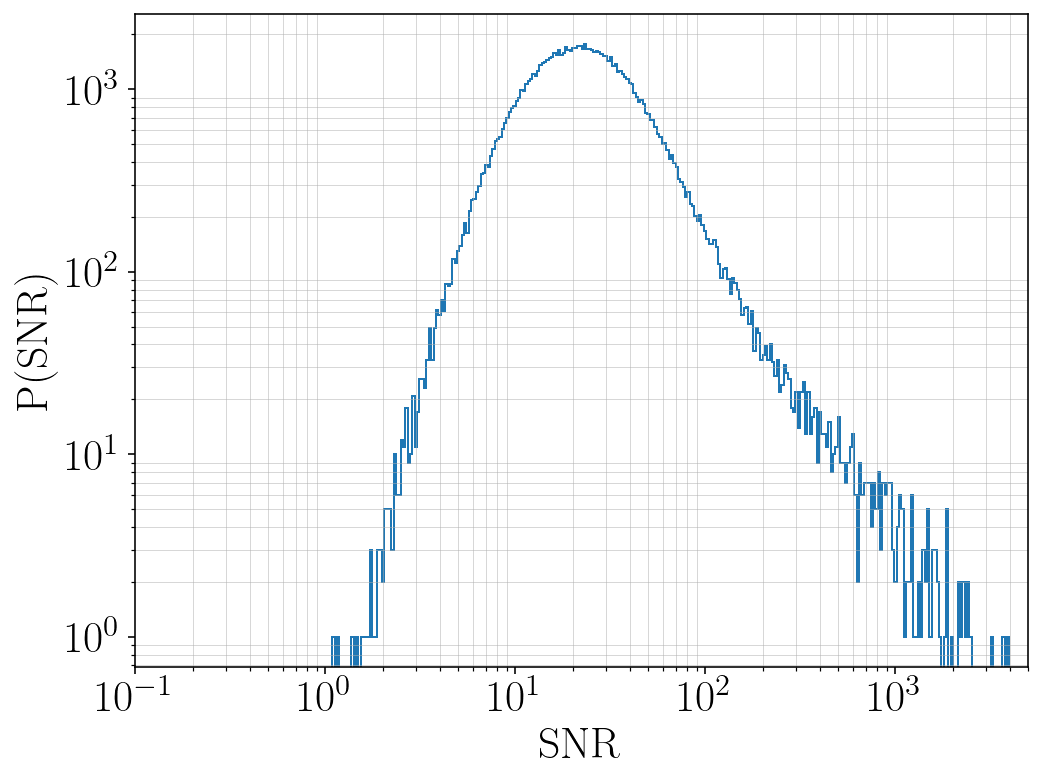

In [ ]:
# compare to Fig. 7 of Iacovelli 2022 (https://iopscience.iop.org/article/10.3847/1538-4357/ac9cd4)
# compare to Fig. 6. of Pieroni 2022 (https://www.nature.com/articles/s41598-022-19540-7)

# The peak of SNR, and overall distribution, is almost identical 
# EVEN THOUGH THEY ARE USING POWER+PEAK!!!


fig, ax = plt.subplots(figsize=(8,6))

bins = np.geomspace(1, 5000, 300)

data = df[(df["hybr"]==0.0) & (df["snr"]>0)]["snr"]
# count, bins_count = np.histogram(data, bins=bins)

plt.hist(data, bins=bins, histtype='step')

ax.grid(which = "minor", linewidth = 0.5, alpha=0.5)
ax.minorticks_on()

plt.xlabel("SNR")
plt.ylabel("P(SNR)")

plt.xlim(1e-1, 5e3)
# plt.ylim(10, 1e4)

plt.loglog()

plt.show()

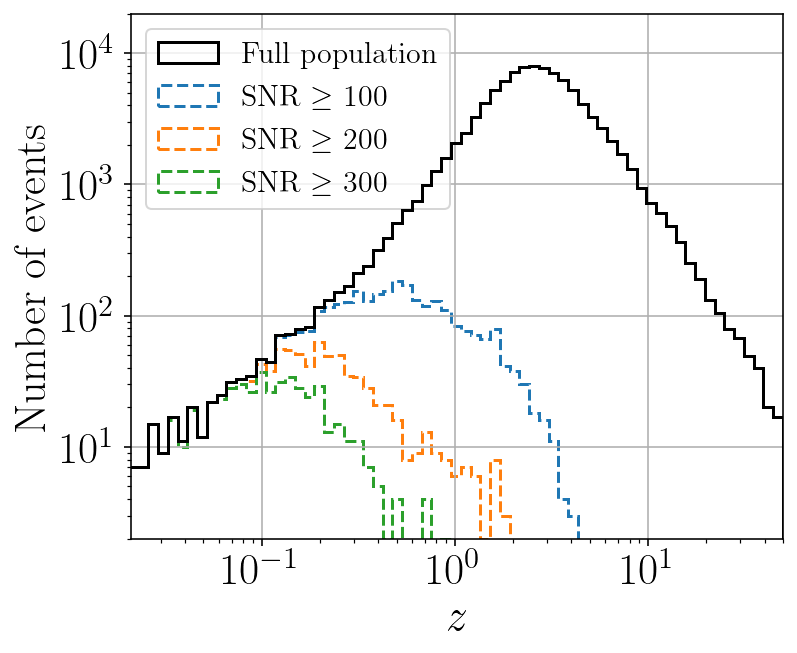

In [ ]:
# Compare to Fig. 11 Iacovelli 2022 (https://iopscience.iop.org/article/10.3847/1538-4357/ac9cd4)
# The SNR distributions match almost perfectly
snrs = [100, 200, 300]

fig, ax = plt.subplots(figsize=(6,5))


data = df[(df["hybr"]==0.0) & (df["snr"]>0)]
bins = np.geomspace(0.001, 100, 100)
# bins = np.linspace(0, 10, 1000)

plt.hist(data["z"], bins=bins, label="Full population", color='k', lw=1.5, histtype='step', zorder=20)

for snr in snrs:
    data = df[(df["hybr"]==0.0) & (df["snr"]>snr)]
    bins = np.geomspace(0.001, 100, 100)
    plt.hist(data["z"], bins=bins, label=f"SNR $\geq$ {snr}", lw=1.5, ls='--', histtype='step')

plt.loglog()
plt.xlim(0.021, 50)
plt.ylim(2, 2e4)
plt.legend(fontsize=15, loc='upper left')
plt.grid()

plt.xlabel("$z$")
plt.ylabel("Number of events")

plt.tight_layout()
plt.show()

## Muttoni 2023, Dark Siren Cosmology

In [ ]:
# cosmology.luminosity_distance(0.25)
# cosmology.luminosity_distance(0.1)
cosmology.luminosity_distance(1e-8)

<Quantity 4.43086699e-05 Mpc>

In [ ]:
data = df[(df["hybr"]==0.0) & (df["snr"]>300) & (df["z"]<1)]
biases = np.abs(data["z_bias"])/data["z_err"]
np.median(biases)

131.35989123687216

## Ng 2021 Pop III inference

In [ ]:
zs = [0.2, 1, 2, 5, 8]
params= ["m1_src", "q", "chi1z", "z"]

for i, param in enumerate(params):
    for j, z in enumerate(zs):
        data = df[(df["hybr"]==0.0) & (df["z"]>z)]
        biases = np.abs(data[param+"_bias"])/data[param+"_err"]
        biases = biases[~np.isnan(biases)]
        print(param, f", z > {z}, median bias = {np.median(biases):.1f}")

m1_src , z > 0.2, median bias = 0.8
m1_src , z > 1, median bias = 0.8
m1_src , z > 2, median bias = 0.6
m1_src , z > 5, median bias = 0.4
m1_src , z > 8, median bias = 0.3
q , z > 0.2, median bias = 2.5
q , z > 1, median bias = 2.6
q , z > 2, median bias = 3.1
q , z > 5, median bias = 5.2
q , z > 8, median bias = 6.2
chi1z , z > 0.2, median bias = 0.8
chi1z , z > 1, median bias = 0.7
chi1z , z > 2, median bias = 0.6
chi1z , z > 5, median bias = 0.6
chi1z , z > 8, median bias = 0.6
z , z > 0.2, median bias = 8.7
z , z > 1, median bias = 8.1
z , z > 2, median bias = 7.0
z , z > 5, median bias = 4.4
z , z > 8, median bias = 3.3


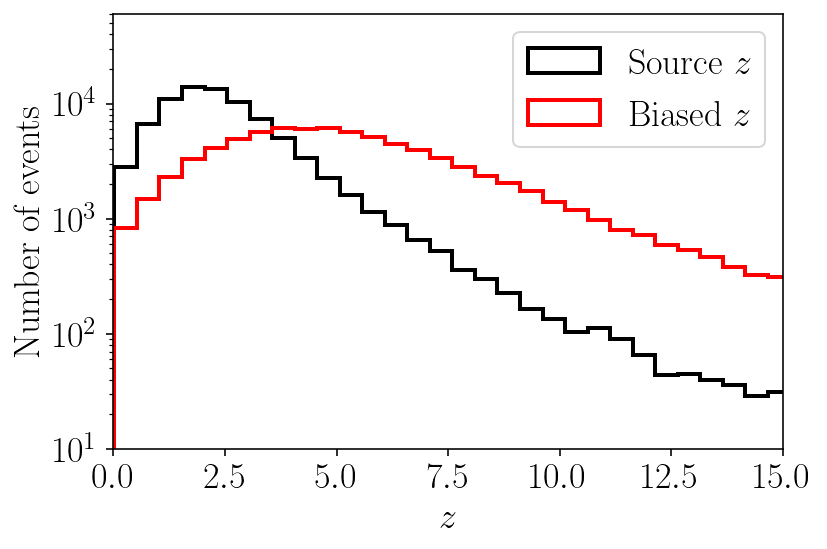

In [ ]:
data = df[(df["hybr"]==0.0) & (df["snr"]>12)]

bins = np.linspace(0.02, 50, 100)
plt.hist(data["z"], bins=bins, histtype='step', lw=2, label='Source $z$', density=False, color='k')
plt.hist(data["z"] + data["z_bias"], bins=bins, lw=2, histtype='step', label="Biased $z$", density=False, color='r')
plt.xlabel('$z$')
plt.ylabel("Number of events")
plt.xlim(0.00, 15.0)
plt.ylim(10, 6e4)
plt.semilogy()
plt.legend()
plt.show()



400 Pop III injections


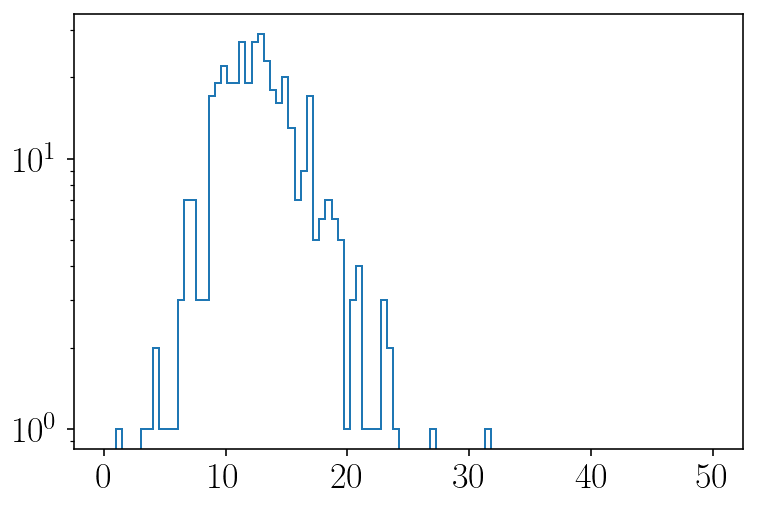

In [ ]:
# create some pop III events
def pop3_z(z, a, b, c):
    return np.exp(a*(z-c)) / (b + a*np.exp((a+b)*(z-c)))

data = df[(df["hybr"]==0.0) & (df["snr"]>12)]

num_injs = int(0.5*0.024*len(data)) #0.024 is the pop III branching ratio
num_injs = 400

print(num_injs, "Pop III injections")

a = 0.66
b = 0.3
c = 11.6

z_range = np.linspace(0.02, 50.0, 10000)
pdf_z= pop3_z(z_range, a,b,c) 
pdf_z = pdf_z/integrate.trapezoid(pdf_z, z_range)

cdf_z = integrate.cumulative_trapezoid(pdf_z, z_range, initial=0)
inv_cdf_z = interpolate.interp1d(cdf_z / cdf_z[-1], z_range)
pop3_z_samples = inv_cdf_z(np.random.rand(num_injs))

bins = np.linspace(0.02, 50, 100)
plt.hist(pop3_z_samples, bins=bins, histtype='step')
plt.semilogy();

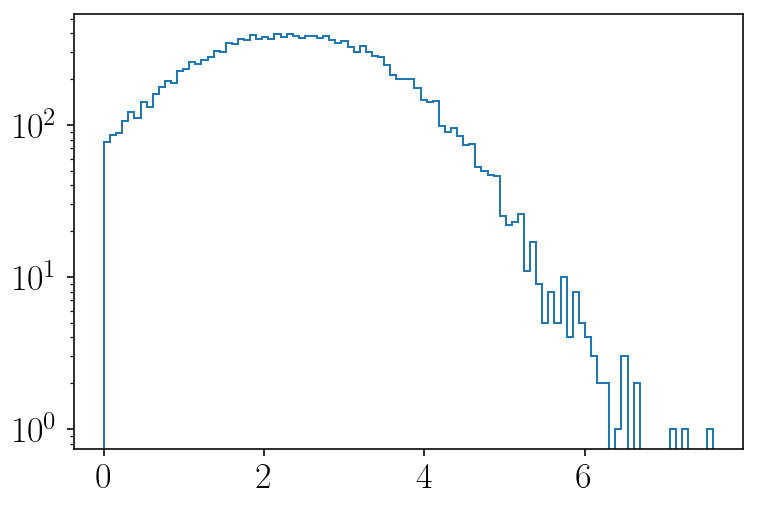

In [ ]:

# create some Cluster events
# mu_z = z_at_value(Planck18.age, 1.63*u.Gyr)
# sigma_z = z_at_value(Planck18.age, 0.96*u.Gyr)
# t_z = z_at_value(Planck18.age, 0.66*u.Gyr)


data = df[(df["hybr"]==0.0) & (df["snr"]>12)]

# num_injs = int(0.5*len(data)) #half of all detections are cluster
num_injs = 16000

cluster_samples = (np.random.normal(2.3, 1.2, size=num_injs))
cluster_samples = cluster_samples[cluster_samples>0]

# cluster_samples_t = (np.random.lognormal(mean=1.63, sigma=0.96, size=1000))
# cluster_samples_t = cluster_samples_t[cluster_samples_t<13.7]

# cluster_samples = z_at_value(Planck18.lookback_time, cluster_samples_t*u.Gyr)

bins = np.linspace(0.02, 50, 100)
plt.hist(cluster_samples, bins=100, histtype='step')
plt.semilogy()
plt.show()

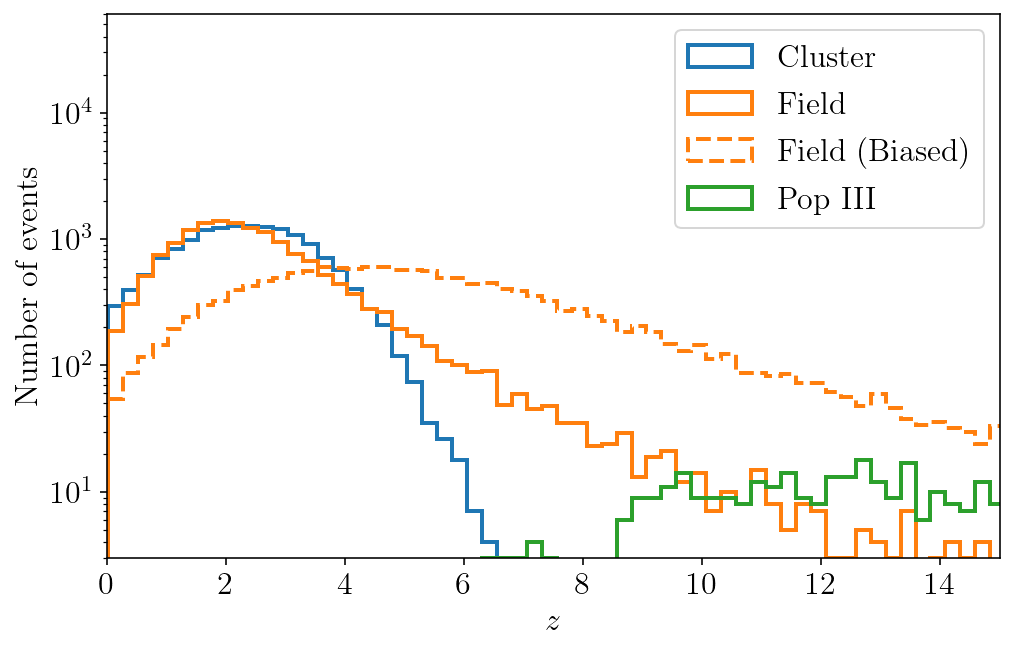

In [ ]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.size": 16
})

data = df[(df["hybr"]==0.0) & (df["snr"]>12)]

num_field = 16000

fig, ax = plt.subplots(figsize=(8, 5))

bins = np.linspace(0.02, 50, 200)

plt.hist(cluster_samples, bins=bins, lw=2, histtype='step', label="Cluster", color='C0')

# plot half the field binaries, since half should be in cluster
plt.hist(data["z"][:num_field], bins=bins, histtype='step', lw=2, label='Field', density=False, color='C1')
plt.hist(data["z"][:num_field] + data["z_bias"][:num_field], bins=bins, lw=2, ls='--', histtype='step', label="Field (Biased)", density=False, color='C1')

plt.hist(pop3_z_samples, bins=bins, lw=2, histtype='step', label="Pop III", color='C2')

# total = np.concatenate((data["z"][::2].values, cluster_samples, pop3_z_samples))
# plt.hist(total, bins=bins, lw=2, histtype='step', label="Total", color='k')

# total = np.concatenate((data["z"][::2]+ data["z_bias"][::2], cluster_samples, pop3_z_samples))
# plt.hist(total, bins=bins, lw=2, histtype='step', color='k', ls='--')

plt.xlabel('$z$')
plt.ylabel("Number of events")
plt.xlim(0.00, 15.0)
plt.ylim(3, 6e4)
plt.semilogy()
plt.legend()
plt.show()



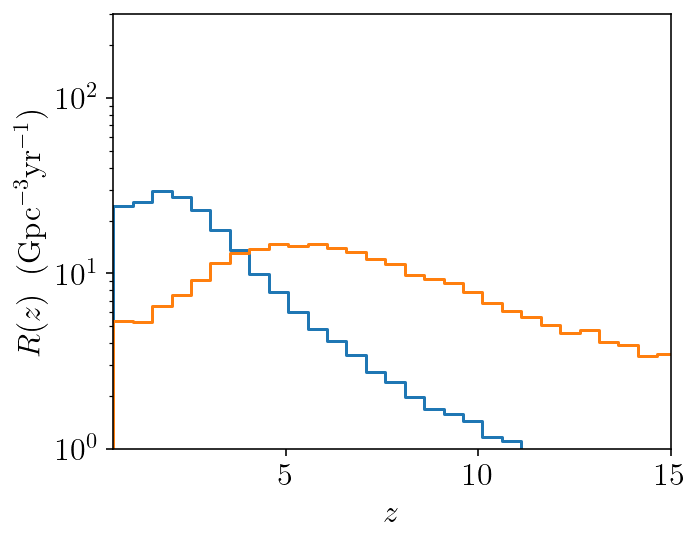

In [ ]:
# Normalize by comoving volume

data = df[(df["hybr"]==0.0)]

fig, ax = plt.subplots(figsize=(5, 4))


z_range = np.linspace(0.01, 50, 100)

volumes_gpc = (cosmology.comoving_volume(z_range[1:]) - cosmology.comoving_volume(z_range[:-1])).to(u.Gpc**3).value

counts, z_bins = np.histogram(data["z"][::2], bins=z_range)
counts[0] = 0
plt.step(z_bins[1:], counts/volumes_gpc)

counts, z_bins = np.histogram(data["z"][::2]+data["z_bias"][::2], bins=z_range)
counts[0] = 0
plt.step(z_bins[1:], counts/volumes_gpc)

counts, z_bins = np.histogram(pop3_z_samples, bins=z_range)
counts[0] = 0
plt.step(z_bins[1:], counts/volumes_gpc)

plt.xlim(0.5, 15.0)
plt.ylim(1, 3e2)
plt.semilogy()

plt.xlabel('$z$')
plt.ylabel("$R(z) \;\; (\\rm Gpc^{-3} yr^{-1})$")

plt.show()


In [ ]:
dl_15 = cosmology.luminosity_distance(15).value

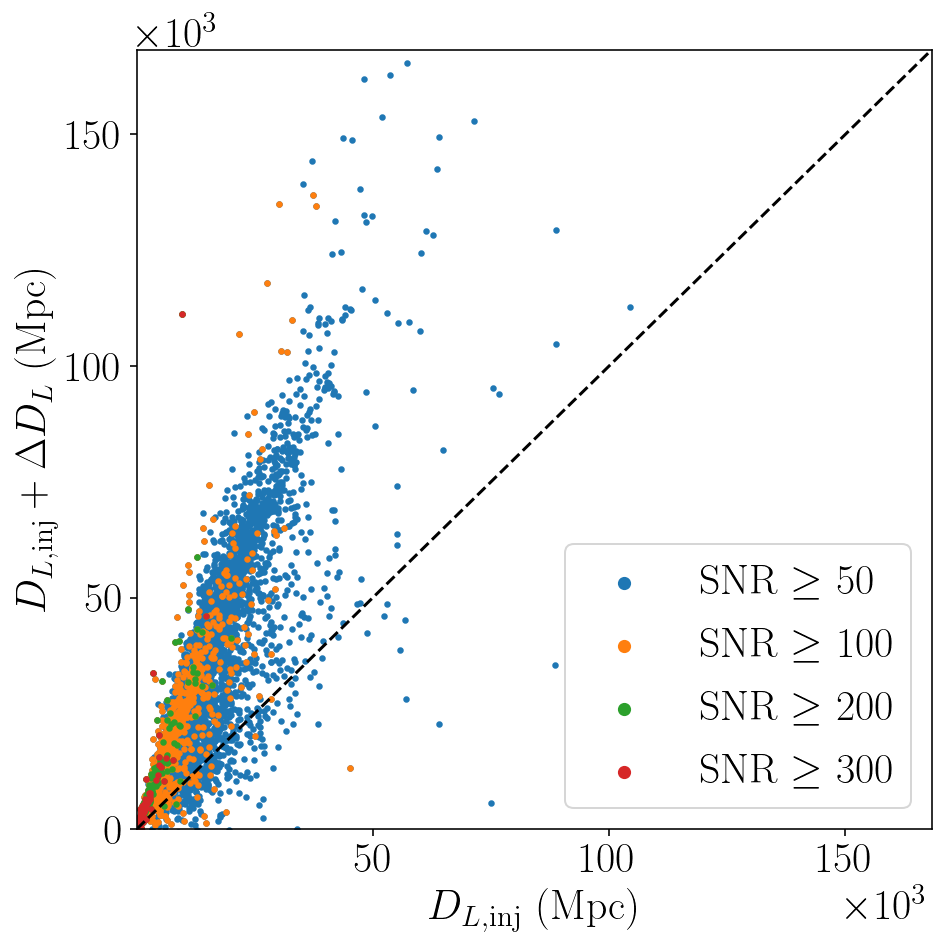

In [ ]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.size": 21
})

fig, ax = plt.subplots(figsize=(7, 7))

for snr in [50, 100, 200, 300]:
    data = df[(df["hybr"]==0.0) & (df["snr"]>snr)]
    plt.scatter(data["DL"], data["DL"]+data["DL_bias"], label=f"SNR $\geq$ {snr}", s=5)

plt.xlabel("$D_{L,\\rm inj}$ (Mpc)")
plt.ylabel("$D_{L,\\rm inj} + \Delta {D_L}$ (Mpc)")


x = np.linspace(0, dl_15, 10)
plt.plot(x, x, ls='--', color='k')
lgnd = plt.legend(markerscale=2.5)

plt.xlim(1.1e2, dl_15)
plt.ylim(1.1e2, dl_15)

plt.yticks(np.arange(0, dl_15, 50e3))

plt.ticklabel_format(axis='both', style='sci', scilimits=(3,3), useMathText=True)
plt.tight_layout()

# plt.savefig("1D_bias_plots/3g_dl_bias_hybr_0.pdf", dpi=300)
plt.show()

# Source-frame vs Detector-frame mass comparison

The overall similarity of the source frame and detector frame biases comes from the bi-directionality of the redshift bias.

When redshift is biased in the negative direction, such that the biased redshift becomes negative, the source frame mass is more biased compared to the detector frame mass. This usually correlates with $i \approx \pi/2$. 

When redshift is biased in the positive direction, the detector frame mass is more biased than the source frame mass.

These two effects compete, so that the overall result of including redshift is cancelled out.

Explanation for $- \Delta z \rightarrow$ source frame bias > detector frame bias:

When the redshift bias is $<0$, the biased $z$ tends to negative, which is unphysical. In these cases, we set the biased $z$ to 0 such that the $m_{1, \rm src}$ bias is approximately equal to the $m_{1, \rm det}$ bias.  Nevertheless, the measurement uncertainty in $m_{1, \rm src}$ becomes smaller by the addition of the $1/(1+z)$ factors to the covariance matrix (see equations). So the bias is more significant.

Explanation for $+ \Delta z \rightarrow$ source frame bias < detector frame bias:

When the redshift bias is $> 0$, there is a non-zero contribution to the $m_{1, \rm src}$ bias from $z$. This effect needs to compete with the $\mathcal{M}_c$ and $\eta$ bias, and so the total bias can be smaller OR larger than the detector mass bias in non-trivial ways. 

The measurement uncertainties are still smaller than the detector frame masses. The overall effect is mixed, with most biases being smaller than the detector frame bias and a few being larger.

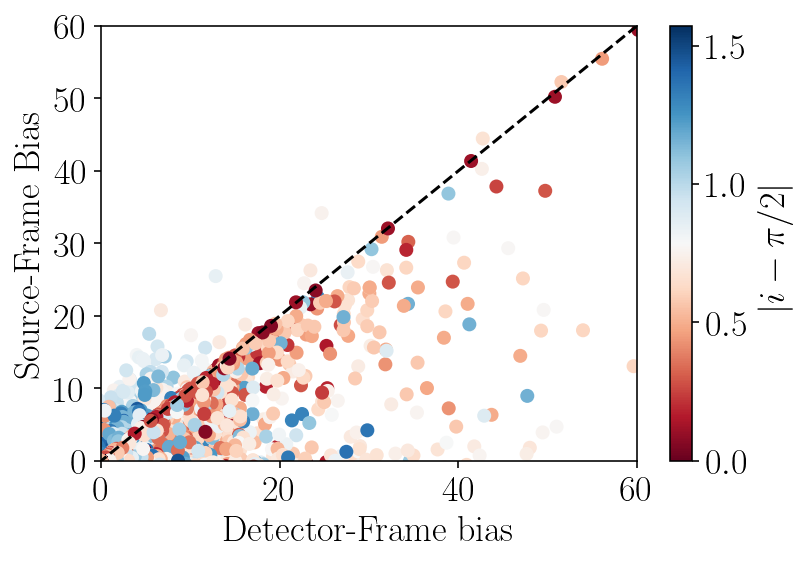

In [ ]:
sc = plt.scatter((df["m1_det_bias"]/df["m1_det_err"]), (df["m1_src_bias"]/df["m1_src_err"]), c=np.abs(df["iota"]-np.pi/2), cmap="RdBu", vmin=0, vmax=np.pi/2)
# sc = plt.scatter(df["iota"],(df["DL_bias"]/df["DL_err"]) , c=np.abs(df["iota"]-np.pi/2), cmap="RdBu", vmin=0, vmax=np.pi/2)

cbar = plt.colorbar(sc)
cbar.set_label("$|i-\pi/2|$")
plt.xlabel("Detector-Frame bias")
plt.ylabel("Source-Frame Bias")
x = np.linspace(-60, 60, 10)
plt.plot(x,x, color='k', ls='--')
plt.xlim(0, 60)
plt.ylim(0, 60)

plt.show()

# Hybr Features

In [ ]:
labels = {
    'Mc': '$\mathcal{M}_c$',
    'eta': '$\eta$',
    'chi1z': '$\chi_{1,\\rm z} \;\;\,$',
    'chi2z': '$\chi_{2, \\rm z}$',
    'DL': '$D_{\\rm L}$',
    'z': '$z \;\;\;\;\;\;$',
    'm1_det': '$m_1$',
    'm2_det': '$m_2$',
    'm1_src': '$m_{1, \\rm src}$',
    'm2_src': '$m_{2, \\rm src}$',
    'chi_eff': '$\chi_{\\rm eff}$',
    'ra': 'ra',
    'dec': 'dec',
    'psi': 'psi',
    'iota': 'iota',
    'q': '$q \;\;\;\;\;\;\,$',
    'm_tot': '$M_{\\rm total}$'
}

## Hybr = 0.0 Median Biases

In [ ]:
data = df[(df["hybr"]==0.0) & (df["snr"]>100)]
print(f"Average Mismatch = {1-np.average(data['faith']):.2e}")

Average Mismatch = 4.42e-03


In [ ]:
snrs = [100, 200, 300]
params= ["m1_src", "m2_src", "m_tot", "q", "chi1z", "chi2z", "z", "DL"]

for i, param in enumerate(params):
    print()
    for j, snr in enumerate(snrs):
        data = df[(df["hybr"]==0.0) & (df["snr"]>snr)]
        biases = np.abs(data[param+"_bias"])/data[param+"_err"]
        biases = biases[~np.isnan(biases)]

        # abs_biases = np.abs(data[param+"_bias"])
        abs_biases = (data[param+"_bias"])
        abs_biases = abs_biases[~np.isnan(abs_biases)]

        rel_biases = np.abs(data[param+"_bias"])/data[param]
        rel_biases = rel_biases[~np.isnan(rel_biases)]
        print(param, f", snr > {snr}, median bias = {np.median(biases):.1f} $\sigma$, {np.median(abs_biases):.2f} units, actual value: {np.median(data[param]):.2f}")




m1_src , snr > 100, median bias = 3.2 $\sigma$, -2.40 units, actual value: 8.57
m1_src , snr > 200, median bias = 5.0 $\sigma$, -1.71 units, actual value: 7.66
m1_src , snr > 300, median bias = 6.3 $\sigma$, -1.30 units, actual value: 7.55

m2_src , snr > 100, median bias = 2.2 $\sigma$, -0.98 units, actual value: 6.03
m2_src , snr > 200, median bias = 2.6 $\sigma$, -0.44 units, actual value: 5.52
m2_src , snr > 300, median bias = 2.8 $\sigma$, -0.28 units, actual value: 5.53

m_tot , snr > 100, median bias = 4.1 $\sigma$, -3.60 units, actual value: 14.71
m_tot , snr > 200, median bias = 5.5 $\sigma$, -2.23 units, actual value: 13.26
m_tot , snr > 300, median bias = 6.5 $\sigma$, -1.69 units, actual value: 12.99

q , snr > 100, median bias = 2.3 $\sigma$, 0.12 units, actual value: 0.76
q , snr > 200, median bias = 3.3 $\sigma$, 0.12 units, actual value: 0.76
q , snr > 300, median bias = 4.3 $\sigma$, 0.11 units, actual value: 0.77

chi1z , snr > 100, median bias = 5.2 $\sigma$, -0.00 

## SNR

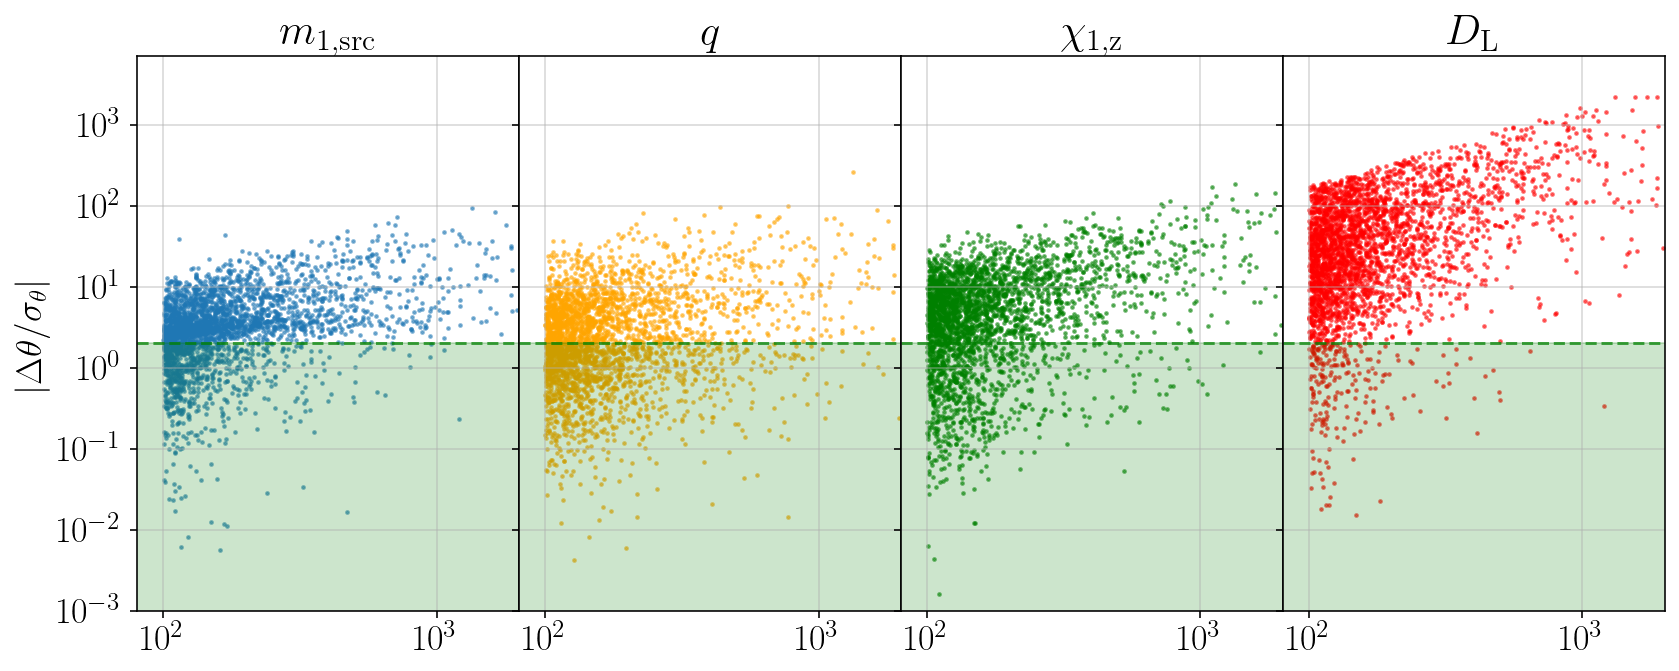

In [ ]:
snr_lim = 100
params= ["m1_src", "q", "chi1z", "DL"]
cs = ["C0", "orange", "g", "red"]

fig, axes = plt.subplots(nrows=1, ncols=len(params), sharey=True, sharex=True, figsize=(12, 5))


data = df[(df["hybr"]==0.0) & (df["snr"]>snr_lim)]
for i, param in enumerate(params):
    axes[i].scatter(data["snr"], np.abs(data[param+"_bias"])/data[param+"_err"], s=2, color=cs[i], alpha=0.5)
    axes[i].set_xscale('log')
    axes[i].set_yscale('log')
    axes[i].set_ylim(1e-3, 7e3)
    axes[i].set_xlim(0.8e2, 2e3)
    
    axes[i].set_title(labels[param])

    axes[i].grid(alpha=0.5)
    
    x = np.linspace(0, 1e5, 3)
    axes[i].axhline(y=2.0, c='g', ls='--', alpha=0.7)
    axes[i].fill_between(x, y1=0, y2=2.0, color='g', alpha=0.2)


axes[0].set_ylabel("$|{\Delta \\theta/\sigma_{\\theta}}|$")

plt.minorticks_off()

# fig.supxlabel("SNR", y=0.13)
plt.tight_layout()
plt.subplots_adjust(wspace=0)


# plt.savefig('1D_bias_plots/hybr_0_bias_vs_snr.pdf', dpi=300)
plt.show()

### Theoretical Faithfulness requirement
from https://journals.aps.org/prd/abstract/10.1103/PhysRevD.95.104004

Faithfulness requirement:
$1-F \lt \frac{D}{2 SNR^2}$

$SNR \lt \sqrt{\frac{D}{2(1-F)}}$

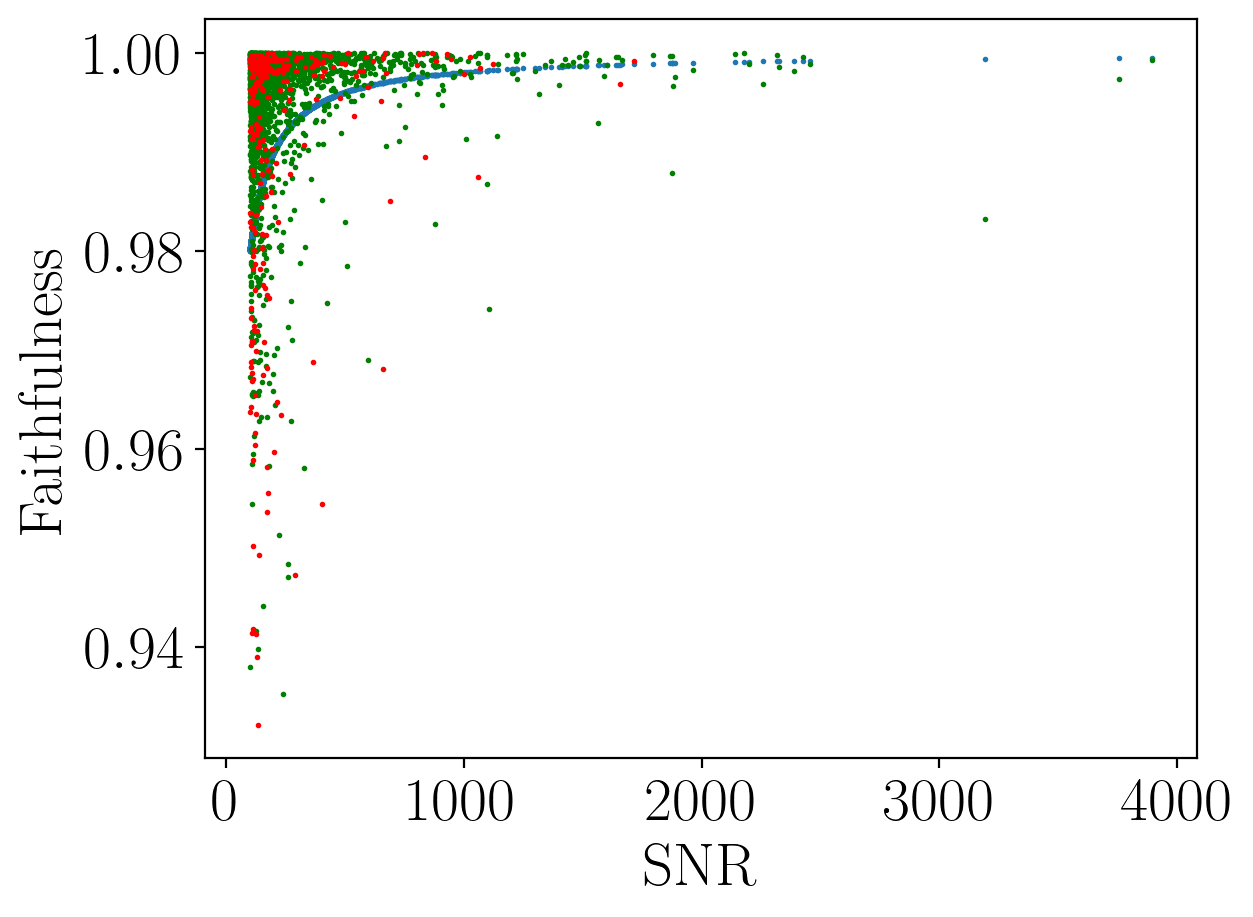

In [ ]:
snr_lim = 100
data = df[(df["hybr"]==0.0) & (df["snr"]>snr_lim)]

snr_faith_lim = 1- np.sqrt(8/(2*data["snr"]**2))

vars=["Mc", "eta", "chi1z"]
bias_mask = np.ones(len(data), dtype=bool)

for var in vars:
    bias_mask = bias_mask * (data[var+"_bias"]/ data[var+"_err"] > 1)


biased_data = data[bias_mask]
unbiased_data = data[~bias_mask]

# # unbiased_data = data[data[var+"_bias"]/ data[var+"_err"] < 1]

plt.scatter(data["snr"], snr_faith_lim, s=1, label="threshold")

plt.scatter(unbiased_data["snr"], unbiased_data["faith"], s=1, c='g')
plt.scatter(biased_data["snr"], biased_data["faith"], s=1, c='r')
plt.xlabel("SNR")
plt.ylabel("Faithfulness")
plt.show()



### figure out which events have large SNR but low bias

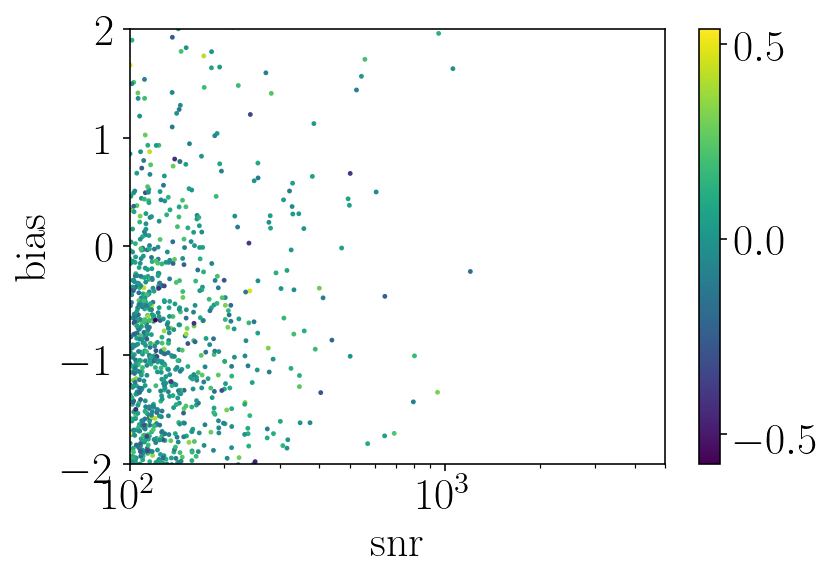

In [ ]:
data = df[(df["hybr"]==0.0) & (df["snr"]>100)]
param="m1_src"


sc = plt.scatter(data["snr"], (data[param+"_bias"])/data[param+"_err"], s=2, c=data["chi2z"])
plt.colorbar(sc)

plt.xlim(100, 5000)
plt.ylim(-2, 2)

plt.semilogx()
plt.xlabel("snr")
plt.ylabel("bias")
plt.show()

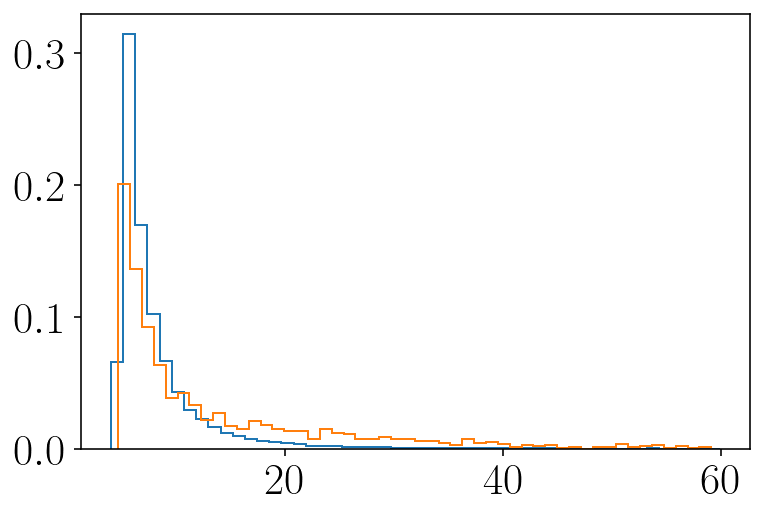

m1_src


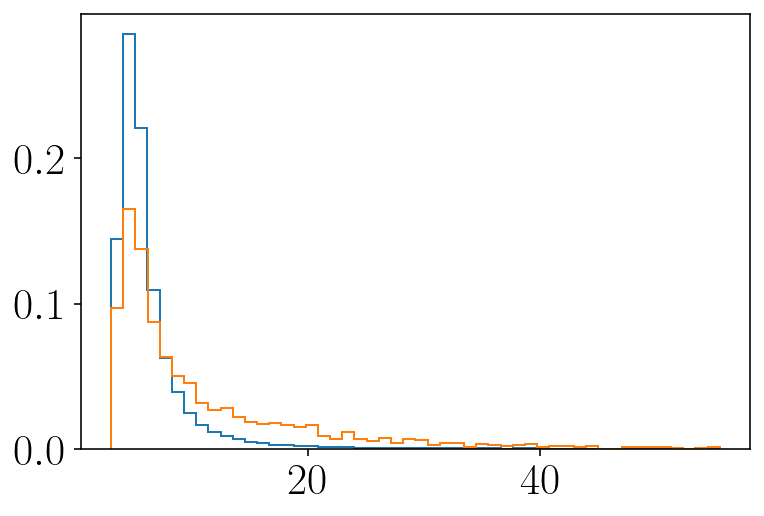

m2_src


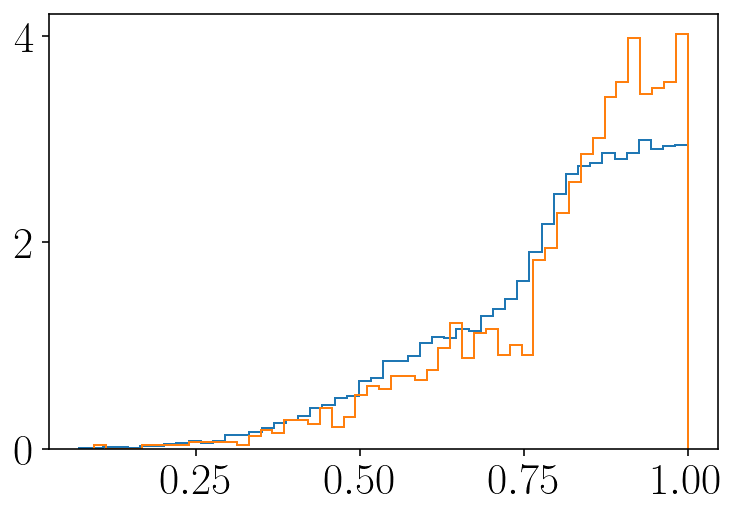

q


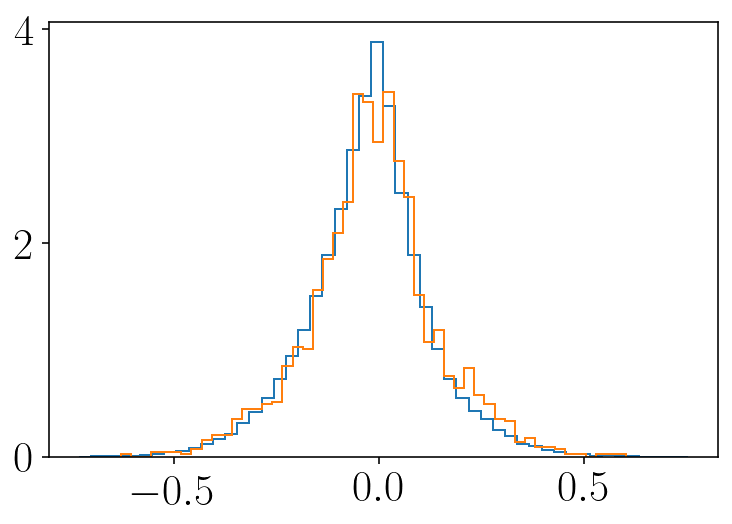

chi1z


In [ ]:
bias_param = "q"
data_all = df[(df["hybr"]==0.0) & (df["snr"]>10) & ((df[bias_param+"_bias"] / df[bias_param+"_err"])<2)]
data_2 = df[(df["hybr"]==0.0) & (df["snr"]>100)& ((df[bias_param+"_bias"] / df[bias_param+"_err"])<2)]

params = ["m1_src", "m2_src", "q", "chi1z"]
for param in params:
    plt.hist(data_all[param], bins=50, histtype='step', density=True)
    plt.hist(data_2[param], bins=50, histtype='step', density=True)
    plt.show()
    print(param)

Seems like equal mass ratio binaries are the ones that survive high snrs.

## Avg Faithfulness

In [ ]:
def plot_avg_vs_hybr(ax, df, quantity, x_qty="hybr", label="", **kwargs):
    hybrs = np.unique(df["hybr"])
    avg_qty = np.zeros_like(hybrs)
    x_data = np.zeros_like(hybrs)
    
    for i, hybr in enumerate(hybrs):
        mask = (df["hybr"]==hybr)
        avg_qty[i] = np.average(quantity[mask])
        x_data[i] = np.average(df[mask][x_qty])

    cs = CubicSpline(x_data, avg_qty)
    ax.scatter(x_data, avg_qty)
    x = np.linspace(0,1,50)
    ax.plot(x, cs(x), label=label)
    # ax.plot(x_data, avg_qty, label=label, **kwargs)


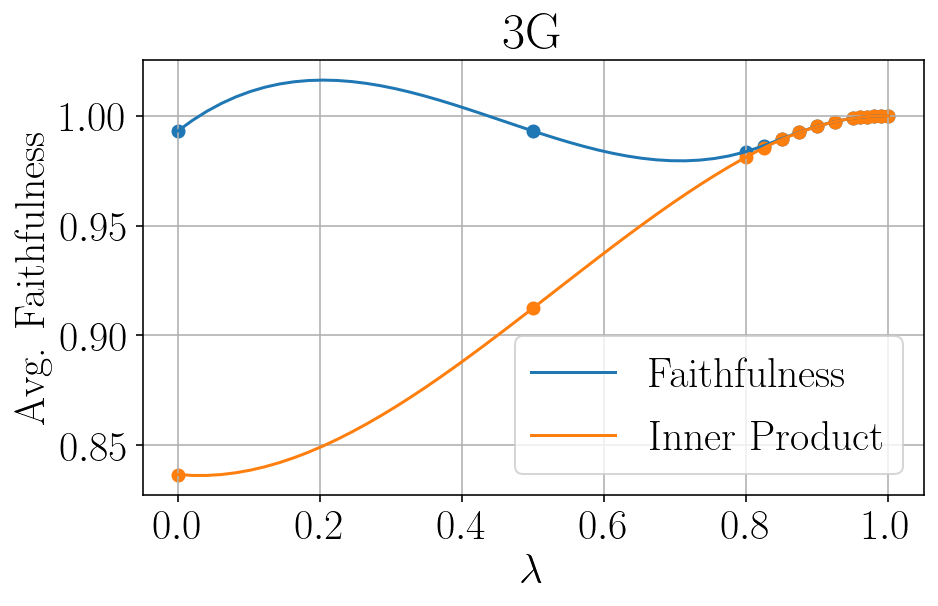

In [ ]:
fig, ax = plt.subplots(figsize=(7, 4))


plot_avg_vs_hybr(ax, df, df["faith"], label="Faithfulness", lw=3)
plot_avg_vs_hybr(ax, df, df["inner_prod"], label="Inner Product", lw=3)


ax.set_xlabel("$\lambda$")
ax.set_ylabel("Avg. Faithfulness")
# plt.ylim(0.95, 1.0)
plt.grid()
# plt.loglog()
plt.title('3G')
plt.legend()
plt.show()

## Average bias vs Faithfulness

In [ ]:
def bias_avg_var_plot(df, ax, hybrs=np.linspace(0.0, 1.0, 1), x_qty="hybr", xlabel='$\lambda$', title='', vars = ['Mc', 'eta', 'chi1z', 'chi2z', 'DL'],
                    legend_loc='upper right', snr_lim = None, labels=None, **kwargs):

    if snr_lim is not None:
        df = df[df["snr"]>snr_lim]
    
    for var in vars:
        x_data = np.zeros_like(hybrs)
        avg_qty = np.zeros_like(hybrs)
        x_data = np.zeros_like(hybrs)
        
        for i, hybr in enumerate(hybrs):
            mask = (df["hybr"]==hybr)
            df_hybr = df[mask]
            quantity = np.abs(df_hybr[f"{var}_bias"]/df_hybr[f"{var}_err"])
            avg_qty[i] = np.average(quantity)
            x_data[i] = np.average(df_hybr[x_qty])

        if labels is None:
            ax.plot(x_data, avg_qty, **kwargs)
        else:
            ax.plot(x_data, avg_qty, label=labels[var], **kwargs)
        

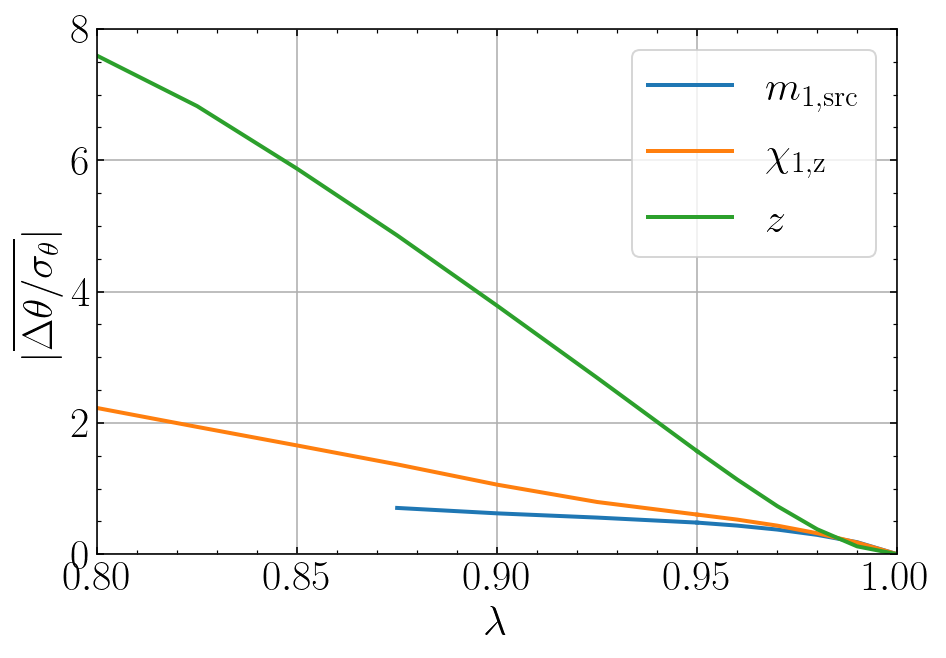

In [ ]:
hybrs = np.unique(df["hybr"])

# vars = ['Mc', 'eta', 'chi1z', 'chi2z', 'DL']
# vars = ['m1', 'm2', 'chi1z', 'chi2z', 'DL']
# vars = ['m1', 'm2', 'chi_eff', 'DL']
vars = ['m1_src', 'chi1z', 'z']

# vars = ["Mc"]




snr_lim=50

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(7, 5))


#
bias_avg_var_plot(df, ax, hybrs[:9], vars=vars, title='3G', labels=None, snr_lim=snr_lim,
                lw=2, linestyle='-')
ax.set_prop_cycle(None)
bias_avg_var_plot(df, ax, hybrs[8:], vars=vars, title='3G', labels=labels, snr_lim=snr_lim,
                lw=2)

ax.set_xlim(0.8, 1.0)
ax.set_ylim(0, 8)


ax.set_xlabel("$\lambda$")
ax.set_ylabel("$|\overline{\Delta \\theta/\sigma_{\\theta}}|$")

plt.legend(loc='upper right')

plt.grid(which='major')
plt.minorticks_on()
plt.tick_params(which='both', direction='in', tick2On=True)

plt.tight_layout()
# plt.savefig('1D_bias_plots/3g_pop_bias_sig_vs_lambda.pdf', dpi=300)

plt.show()

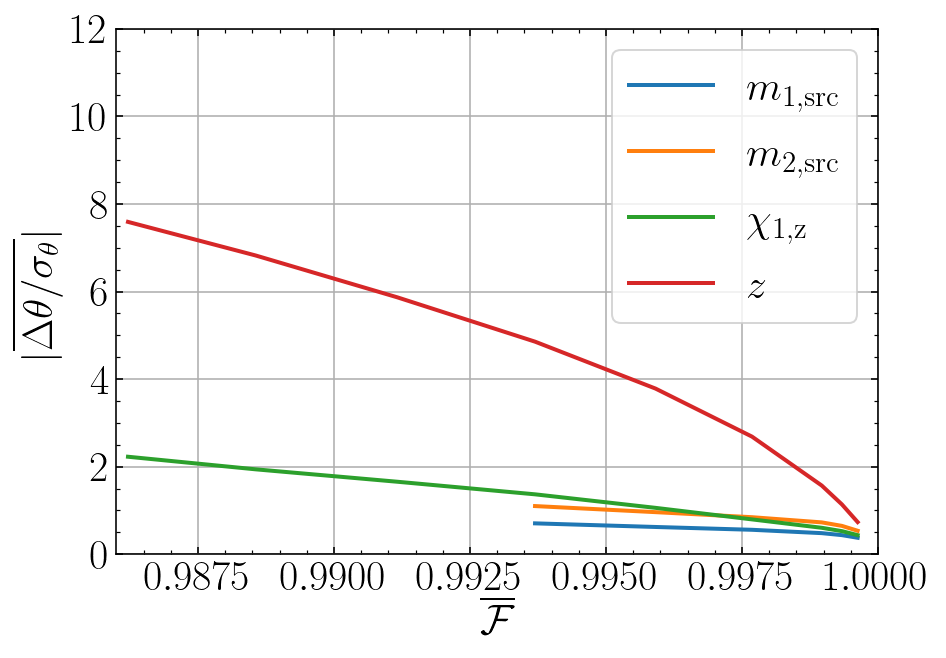

In [ ]:
hybrs = np.unique(df["hybr"])[2:]

# vars = ['Mc', 'eta', 'chi1z', 'chi2z', 'DL']
# vars = ['m1', 'm2', 'chi1z', 'chi2z', 'DL']
# vars = ['m1', 'm2', 'z']
# vars = ['m1', 'm1_src', 'z']
vars = ['m1_src','m2_src', 'chi1z', 'z']

# vars = ["Mc"]

snr_lim = 50
n_sigma = 2
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(7, 5))


bias_avg_var_plot(df, ax, hybrs[:9], x_qty="faith", vars=vars, title='3G', labels=labels, snr_lim=snr_lim,
                lw=2, linestyle='-')


ax.set_xlabel("$\overline{\mathcal{F}}$")
ax.set_ylabel("$|\overline{\Delta \\theta/\sigma_{\\theta}}|$")

plt.legend(loc='upper right')

plt.grid(which='major')
plt.minorticks_on()
plt.tick_params(which='both', direction='in', tick2On=True)

ax.set_ylim(0, 12)
ax.set_xlim(0.986, 1.0)

plt.tight_layout()
# plt.savefig('1D_bias_plots/3g_pop_bias_sig_vs_faith.pdf', dpi=300)

plt.show()

## % of Biased events from Total Population

In [ ]:
def bias_perc_plot(df, ax, hybrs, n_sigma=1.0, x_qty="hybr", xlabel='$\lambda$', title='', vars = ['Mc', 'eta', 'chi1z', 'chi2z', 'DL'], snr_factor = 1.0,
                    legend_loc='upper right', snr_lim = None, labels=None, **kwargs):

    snr_cut_str = " "
    if snr_lim is not None:
        df = df[df["snr"]>snr_lim]
        snr_cut_str = f"SNR>{snr_lim:.1f}"
    

    for var in vars:
        x_data = np.zeros_like(hybrs)
        bias_perc = np.zeros_like(hybrs)
        bias_num = np.zeros_like(hybrs)
        for i, hybr in enumerate(hybrs):
            df_hybr = df[df["hybr"]==hybr]
            x_data[i] = np.average(df_hybr[x_qty])

            data = snr_factor* df_hybr[f"{var}_bias"]/df_hybr[f"{var}_err"]
            bias_perc[i] = 100* np.sum(np.abs(data)>n_sigma) / len(data)
            bias_num[i] = np.sum(np.abs(data)>n_sigma)

        if labels is None:
            ax.plot(1-x_data, bias_perc, **kwargs)
        else:
            cs = CubicSpline(x_data, bias_perc)
            x = np.linspace(x_data[0], x_data[-1], 10000)
            ax.plot(1-x, cs(x), label=labels[var], **kwargs)
            # ax.plot(x_data, bias_perc, label=labels[var], **kwargs)
            
        

    ax.set_xlabel(xlabel)
    # ax.set_ylabel(f"Biased Events (%)")
    # ax.set_title(f"{title} Bias Percentage ($\geq${n_sigma}$\sigma$)")

In [ ]:
# hybrs = np.unique(df["hybr"])

# # vars = ['Mc', 'eta', 'chi1z', 'chi2z', 'DL']
# # vars = ['m1', 'm2', 'chi1z', 'chi2z', 'DL']
# # vars = ['m1', 'm2', 'chi_eff', 'DL']
# vars = ['m1_det', 'q', 'chi1z', 'z']

# # vars = ["Mc"]




# snr_lim= 50
# n_sigma = 2
# fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(7, 5))

# bias_perc_plot(df, ax, hybrs[:], n_sigma=n_sigma, vars=vars, title='3G', labels=labels, snr_lim=snr_lim,
#                 lw=2, linestyle='-')

# # ax.set_ylim(0, 60)
# ax.set_xlim(0.95, 1.0)
# # ax.set_xscale('log')

# ax.set_ylabel('$\geq 2\sigma$ Bias (\%)')
# ax.set_xlabel("$\lambda$")

# plt.legend(loc='upper right')

# plt.grid(which='major', alpha=0.5)
# plt.minorticks_on()
# plt.tick_params(which='both', direction='in', tick2On=True)



# plt.tight_layout()
# # plt.savefig('1D_bias_plots/3g_pop_percentage_vs_lambda.pdf', dpi=300)

# plt.show()

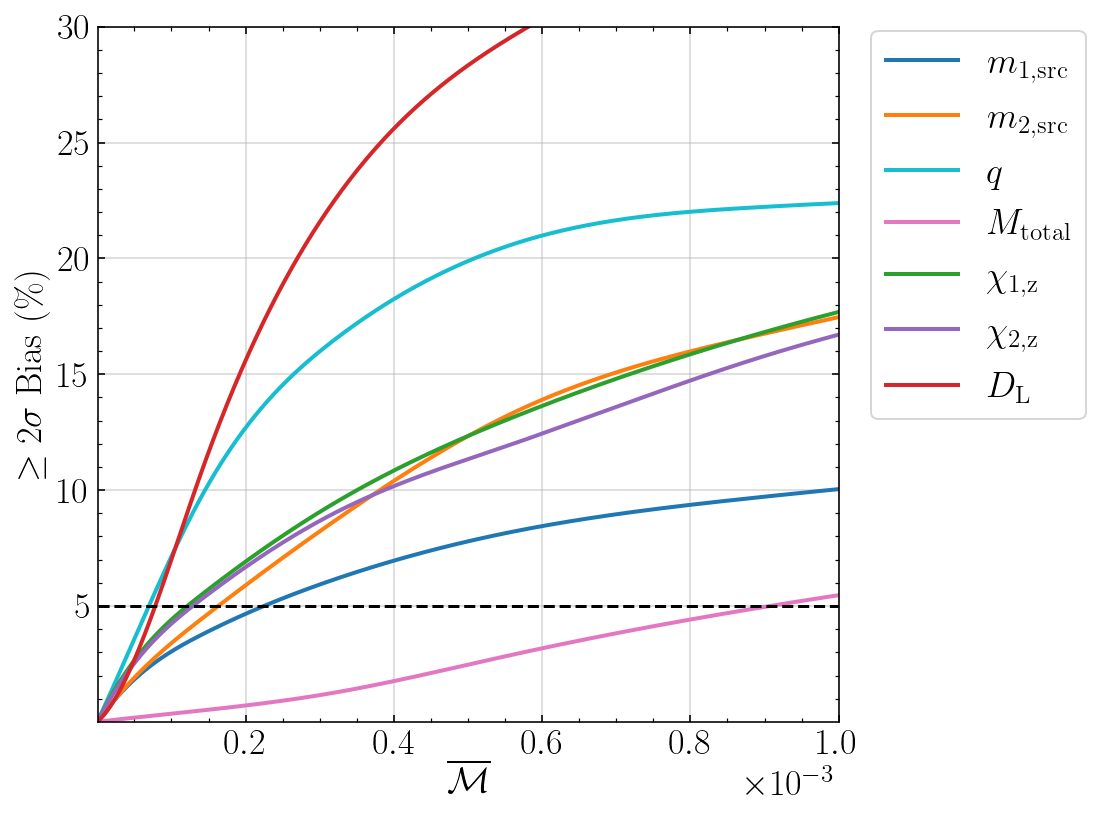

In [ ]:
from cycler import cycler

hybrs = np.unique(df["hybr"])[2:]
# hybrs = [0.0, 0.8, 0.825, 0.85, 0.875, 0.9, 0.925, 0.96, 0.97, 0.98, 0.99,  1.0]

# vars = ['Mc', 'eta', 'chi1z', 'chi2z', 'DL']
# vars = ['m1', 'm2', 'chi1z', 'chi2z', 'DL']
# vars = ['m1', 'm2', 'chi_eff', 'DL']
vars = ['m1_src', 'm2_src',  'q', 'm_tot', 'chi1z', 'chi2z', 'DL']
# vars=["m_tot"]
custom_cycler = (cycler(color=['tab:blue', 'tab:orange', 'tab:cyan', 'tab:pink', 'tab:green', 'tab:purple', 'tab:red']) 
                #  + cycler(linestyle=['-', '-', '-.', '-.', '-', '-', '-'])
                 )

snr_lim= 100
n_sigma = 2


fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(8, 6))


ax.set_prop_cycle(custom_cycler)

bias_perc_plot(df, ax, hybrs[:], n_sigma=n_sigma, x_qty="faith", xlabel="Avg Faithfulness", vars=vars, title='3G', labels=labels, snr_lim=snr_lim,
                lw=2)



plt.axhline(y=5, ls='--', color='k')
ax.set_ylim(0.0001, 30.0)
# ax.set_xlim(0.000001, 1-0.99952)
ax.set_xlim(0.000001, 1e-3)


ax.set_ylabel(f'$\geq {n_sigma}\sigma$ Bias (\%)')
ax.set_xlabel("$\overline{\mathcal{M}}$")

plt.legend(bbox_to_anchor=(1.02, 1.02), loc='upper left')

plt.grid(which='major', alpha=0.5)
plt.minorticks_on()
plt.tick_params(which='both', direction='in', tick2On=True)
plt.ticklabel_format(axis='x', style='sci', scilimits=(0,0), useMathText=True)

plt.tight_layout()

# plt.savefig('1D_bias_plots/3g_pop_percentage_vs_faith.pdf', dpi=300)
plt.show()


# Relative Bias Histograms

In [ ]:
labels = {
    'Mc': '$\mathcal{M}_c$',
    'eta': '$\eta$',
    'chi1z': '$\chi_{1,\\rm z} \;\;\,$',
    'chi2z': '$\chi_{2, \\rm z}$',
    'DL': '$D_{\\rm L}$',
    'z': '$z \;\;\;\;\;\;$',
    'm1_det': '$m_1$',
    'm2_det': '$m_2$',
    'm1_src': '$m_{1, \\rm src}$',
    'm2_src': '$m_{2, \\rm src}$',
    'chi_eff': '$\chi_{\\rm eff}$',
    'ra': 'ra',
    'dec': 'dec',
    'psi': 'psi',
    'iota': 'iota',
    'q': '$q \;\;\;\;\;\;\,$'
}

In [ ]:
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.size": 22
})

In [ ]:
def bias_hist_plot(df, ax, hybr='0.9', title='', vars = ['Mc', 'eta', 'chi1z', 'chi2z', 'DL'], n_sigma=2.0, snr_factor = 1.0,
                    bins=30, legend_loc='upper right', snr_lim = None ,kde=False, labels=None, 
                    hyb_text = True, hyb_text_x=-18, hyb_text_y=2.7, 
                    faith_text = True, faith_text_x=-18, faith_text_y=1.0, **kwargs):
    mask = (df['hybr']==hybr)

    snr_cut_str = " "
    if snr_lim is not None:
        mask = mask & (df["snr"]>snr_lim)
        snr_cut_str = f"SNR>{snr_lim:.1f}"
    
    df = df[mask]

    for var in vars:
        data = snr_factor* df[f"{var}_bias"]/df[f"{var}_err"]
        bias_num = np.sum(np.abs(data)>n_sigma)
        bias_perc = 100* np.sum(np.abs(data)>n_sigma) / len(data)
        if labels is None:
            label=var + f" ({bias_perc:.1f}\% biased)"
        else:
            # label = labels[var] + "  ($N_{\\rm bias}$ = " + f"{bias_num})"
            label = labels[var] + f" ({bias_perc:.1f}\% biased)"
        if not kde:
            ax.hist(data, bins=bins, histtype='step', label=label, **kwargs)
        else:
            sns.kdeplot(data=data, ax=ax, bw_adjust=1, gridsize=1000, label=label)

    # ax.set_xlabel("$\Delta \\theta / \sigma_{\\theta}$")
    # ax.set_title(title)
    if hyb_text:
        ax.text(hyb_text_x, hyb_text_y, f'$\lambda$={hybr:.2f}', fontsize=20)
    
    if faith_text:
        faith = np.average(df["faith"])
        ax.text(faith_text_x, faith_text_y, "$\overline{\mathcal{M}} = $"+f" {1-faith:.1e}", fontsize=20)

    ax.legend(loc=legend_loc, fontsize=20)
    
    # ticks
    ax.tick_params(labelbottom=False, direction="in", which='major', length=5.0, width=1.0, top=True)



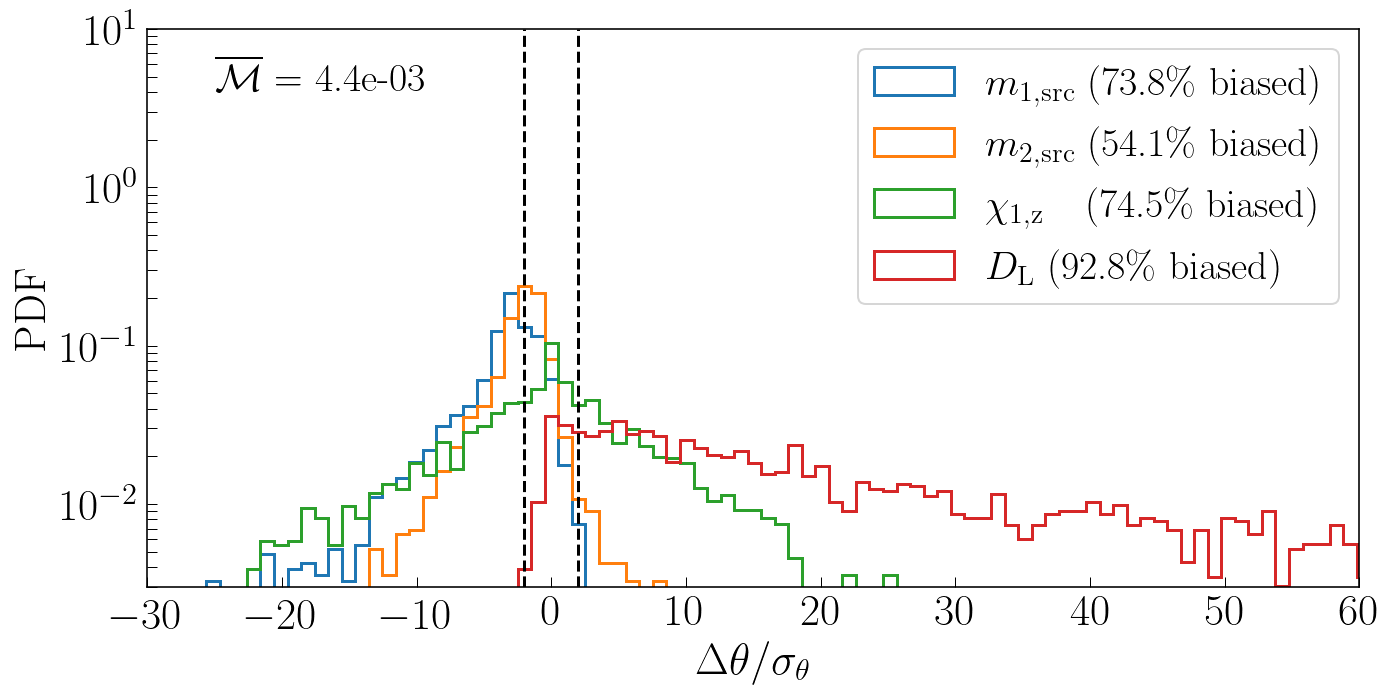

In [ ]:
hybr=0.0
fig, ax = plt.subplots(ncols=1, nrows=1, sharex=True, figsize=(10, 5))

# vars = ['m1_src', 'q']
# vars = ['m1', 'm2', 'chi1z', 'chi2z', 'DL']
# vars = ['m1', 'm2', 'chi_eff', 'DL']
vars = ['m1_src', 'm2_src', 'chi1z', 'DL']



bins=np.linspace(-100, 100, 200)
# bins=30

snr_lim= 100

bias_hist_plot(df, ax, hybr=hybr, title='', n_sigma=2.0, vars=vars, bins=bins, labels=labels, snr_lim=snr_lim,
               hyb_text=False, faith_text=True, hyb_text_x=-25, faith_text_x=-25, faith_text_y=4,
            lw=1.5, density=True, kde=False)


# ax.text(x=-5, y=-1, s="IMRPhenomXAS", fontsize=18)


ax.axvline(x=2, color='k', ls='--')
ax.axvline(x=-2, color='k', ls='--')

ax.set_xlim(-30, 60)
ax.minorticks_off()
ax.set_ylim(0.003, 10)
ax.set_yscale('log')

ax.set_ylabel('PDF')

    
plt.xlabel("$\Delta \\theta / \sigma_{\\theta}$")
plt.tight_layout()

ax.tick_params(labelbottom=True, direction="in", length=5.0, width=.5, which="both", top=False)

# plt.savefig('1D_bias_plots/3g_pop_bias_histogram_hybr_0.pdf', dpi=300)

plt.show()

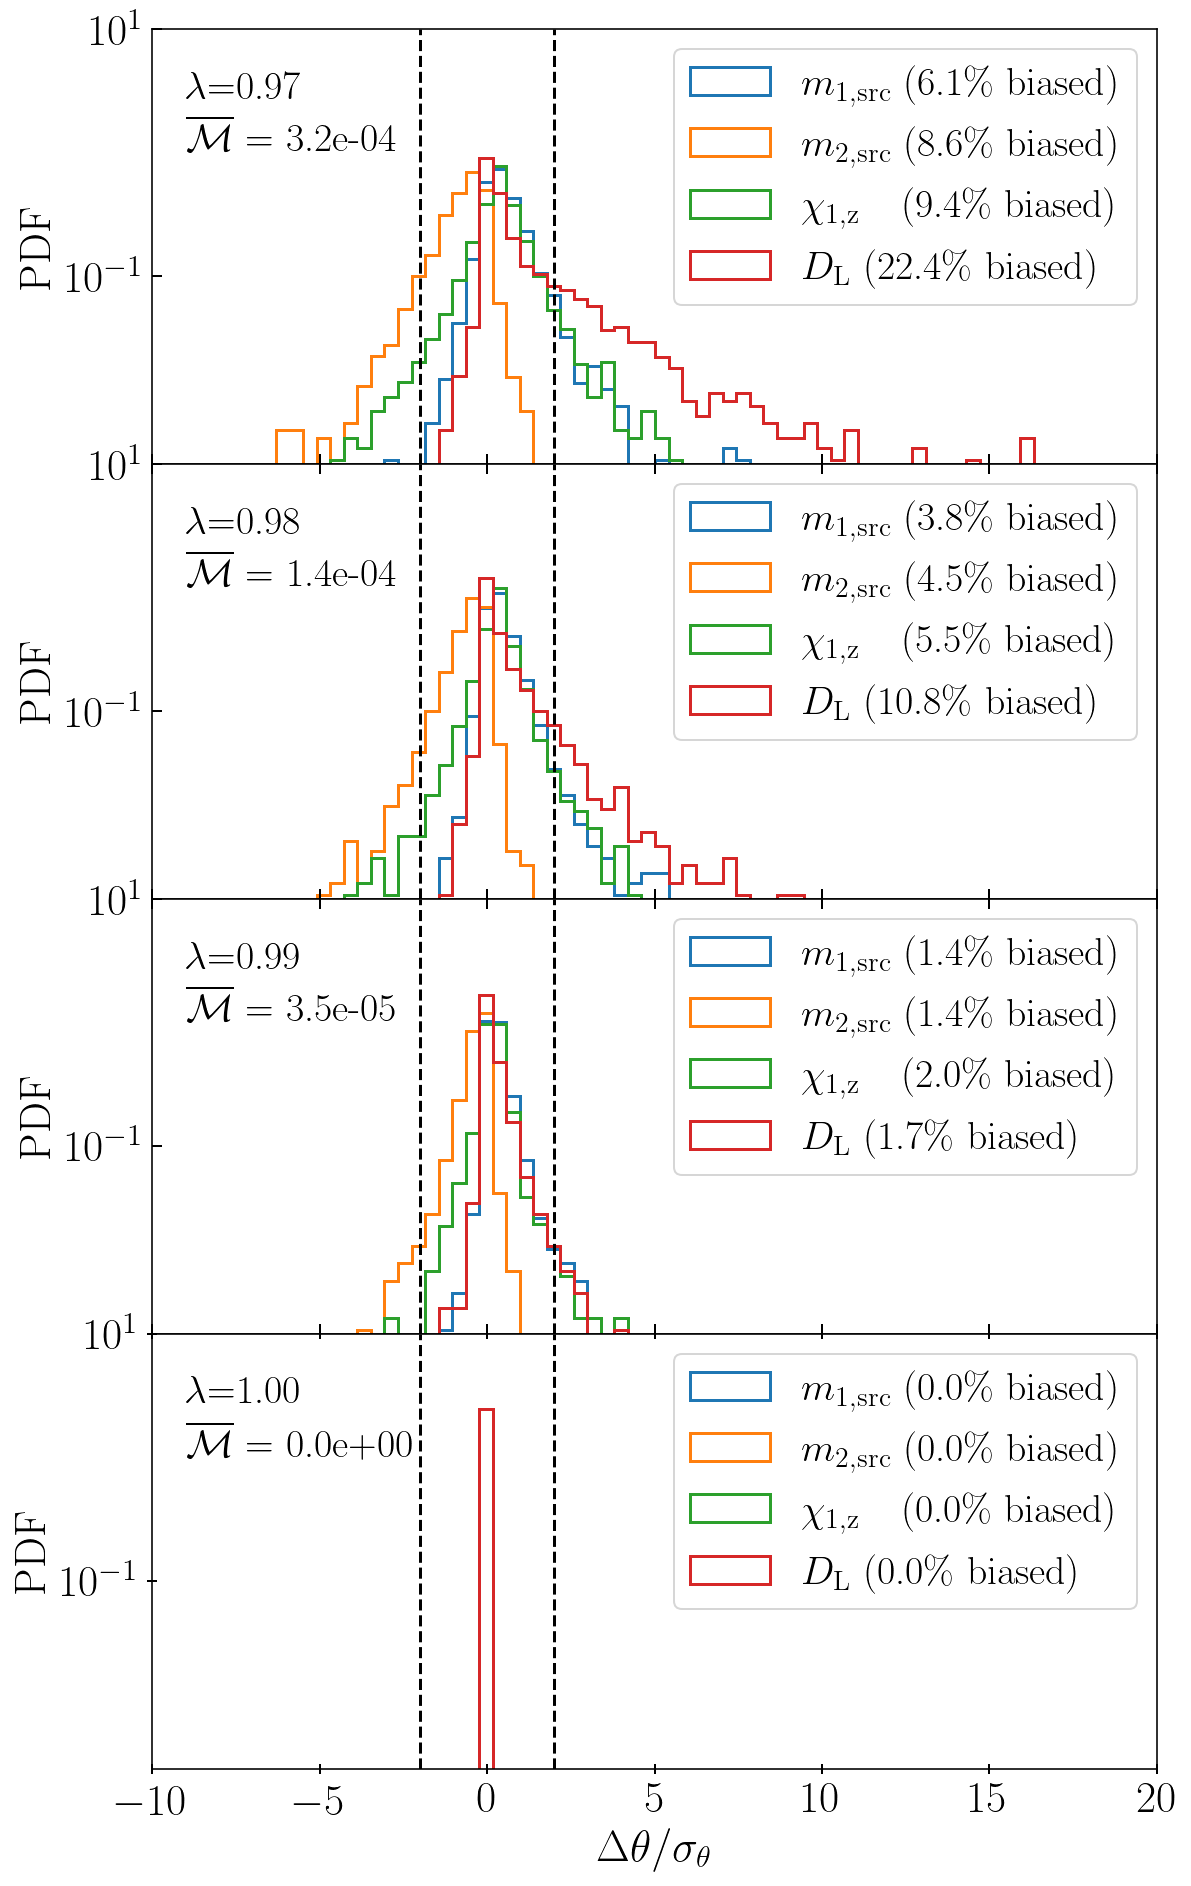

In [ ]:
# hybrs = np.unique(df["hybr"])
hybrs = [0.97, 0.98, 0.99, 1.0]

fig, axes = plt.subplots(ncols=1, nrows=len(hybrs), sharex=True, figsize=(9, 4*len(hybrs)))

# vars = ['m1_src', 'q']
# vars = ['m1', 'm2', 'chi1z', 'chi2z', 'DL']
# vars = ['m1', 'm2', 'chi_eff', 'DL']
vars = ['m1_src', 'm2_src', 'chi1z', 'DL']



bins=np.linspace(-16, 24, 100)
# bins=30

snr_lim= 100

for i, hybr in enumerate(hybrs):
    bias_hist_plot(df, axes[i], hybr=hybr, title=f'$\lambda$={hybr:.2f}', n_sigma=2.0, vars=vars, bins=bins, labels=labels, snr_lim=snr_lim,
                 hyb_text_x=-9, faith_text_x=-9,
                lw=1.5, density=True, kde=False)

axes[0].tick_params(labelbottom=False, direction="in", which='both', length=5.0, width=1.0, top=False)
axes[-1].tick_params(labelbottom=True, direction="inout", length=5.0, width=1.0, which="both", top=True)


for ax in axes:
    ax.axvline(x=2, color='k', ls='--')
    ax.axvline(x=-2, color='k', ls='--')
    ax.set_xlim(-10, 20)
    ax.set_ylim(0.0, 3.5)
    ax.minorticks_off()
    ax.set_ylim(0.003, 10)
    ax.set_yscale('log')
    ax.set_ylabel('PDF')
    
plt.xlabel("$\Delta \\theta / \sigma_{\\theta}$")

plt.subplots_adjust(hspace=.0)

# plt.tight_layout()

# plt.savefig('1D_bias_plots/3g_pop_bias_histograms.pdf', dpi=300)

plt.show()

### mini-investigation: why is m1 bias negative for $\lambda=0$ but positive for $\lambda=1$ ?

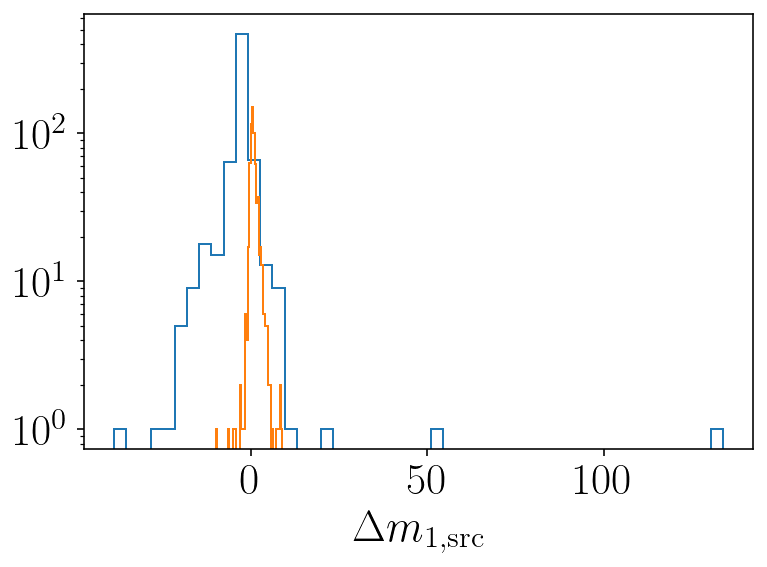

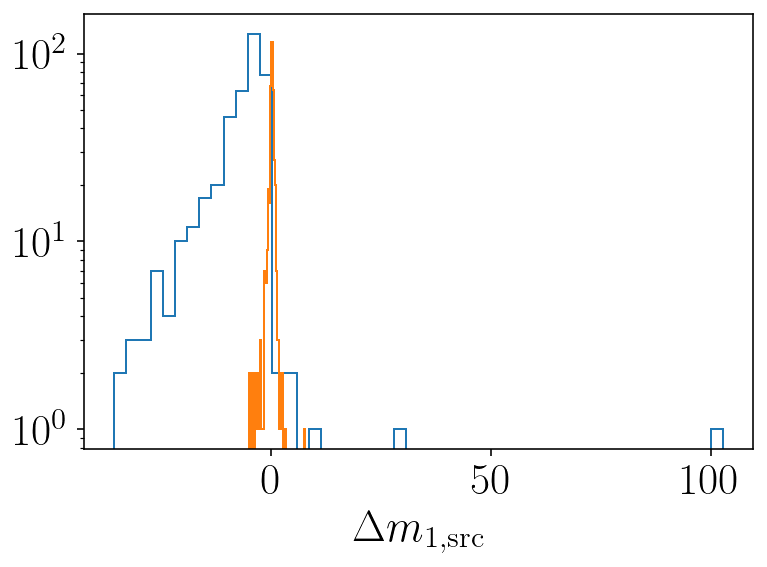

In [ ]:
bins = 50

data = df[(df["hybr"]==0.0) & (df["snr"]>100) & (df["q"]>0.9)]
plt.hist(data["m1_src_bias"], bins=bins, histtype='step');

data = df[(df["hybr"]==0.97) & (df["snr"]>100) & (df["q"]>0.9)]
plt.hist(data["m1_src_bias"],bins=bins, histtype='step');

plt.xlabel("$\Delta m_{1, \\rm src}$")

plt.semilogy()
plt.show()


data = df[(df["hybr"]==0.0) & (df["snr"]>100) & (df["q"]<0.5)]
plt.hist(data["m1_src_bias"], bins=bins, histtype='step');

data = df[(df["hybr"]==0.97) & (df["snr"]>100) & (df["q"]<0.5)]
plt.hist(data["m1_src_bias"],bins=bins, histtype='step');

plt.xlabel("$\Delta m_{1, \\rm src}$")

plt.semilogy()
plt.show()


As we go from IMRPhenomD to IMRPhenomXAS, the differences in the extreme mass-ratio binaries are huge. Going from one to the other, I can check which part of the waveform disagree wildly (inspiral vs merger). That might give some hint as to what's going on. If the hybrid waveforms have some behavior that makes them mimic more high mass 

# Identify 3 interesting Binaries to study with Bayesian PE

In [ ]:
labels = {
    'Mc': '$\mathcal{M}_c$',
    'eta': '$\eta$',
    'chi1z': '$\chi_{1,\\rm z}$',
    'chi2z': '$\chi_{2, \\rm z}$',
    'DL': '$D_{\\rm L}$',
    'z': '$z$',
    'm1_det': '$m_1$',
    'm2_det': '$m_2$',
    'm1_src': '$m_{1, \\rm src}$',
    'm2_src': '$m_{2, \\rm src}$',
    'chi_eff': '$\chi_{\\rm eff}$',
    'ra': 'ra',
    'dec': 'dec',
    'psi': 'psi',
    'iota': 'iota',
    'q': '$q$'
}

In [ ]:
import scipy.stats as stats

def plot_bias(index, vars, labels, hybr=0.0, hybr_2=None):
    fig, axes = plt.subplots(ncols=1, nrows=len(vars), figsize=(8, 3*len(vars)))
    ax = list(axes)
    
    df_bias = df[(df["hybr"]==hybr) * df["index"]==index]
    if hybr_2 is not None:
        df_2_bias = df[(df["hybr"]==hybr_2) * df["index"]==index]

    for i, param in enumerate((vars)):
        mu = df_bias[param]
        sigma = df_bias[param+"_err"]
        bias = df_bias[param+"_bias"]

        x = np.linspace(mu-3*bias, mu+3*bias, 10000)
        if (param == 'chi1z' or param == 'chi2z'):
            x = np.linspace(-1, 1, 10000)
        if (param == 'q'):
            x = np.linspace(0, 1, 10000)
        if (param == 'eta'):
            x = np.linspace(0, 0.25, 10000)
        if (param == 'DL' or param == 'z' or param=='Mc' or param=='m1_det' or param=='m1_src' or param=='m2_det' or param=='m2_src'):
            x = np.linspace(np.maximum(0, mu-np.abs(3*bias)), mu+np.abs(3*bias), 10000)

        inj_est = stats.norm.pdf(x, mu, sigma)
        inj_est = inj_est/np.sum(inj_est)

        biased_est = stats.norm.pdf(x, mu+bias, sigma)
        biased_est = biased_est/ np.sum(biased_est)

        # print(bias/sigma)
        
        ax[i].plot(x, inj_est, label=f"Injected (IMRPhenomXAS)", color='k', lw=2)
        ax[i].plot(x, biased_est, label=f"Recovered (IMRPhenomD)",color='r', lw=2)

        if hybr_2 is not None:
            bias_2 = df_2_bias[param+"_bias"]
            biased_est_2 = stats.norm.pdf(x, mu+bias_2, sigma)
            biased_est_2 = biased_est_2/ np.sum(biased_est_2)
            ax[i].plot(x, biased_est_2, label=f"Hybrid ($\lambda=${hybr_2:.2f})",color='orange', lw=2)

        ax[i].set_xlabel(labels[param])
        ax[i].set_ylabel(f"p({labels[param]})")
        
        if i==0:
            ax[i].legend(bbox_to_anchor=(1.1, 1), fontsize=14)


    # plt.suptitle( " Systematic Bias \n IMRPhenomXAS and IMRPhenomD", y=1.02, fontsize=20)
    plt.tight_layout()
    plt.show()

In [ ]:
def plot_bias_hybrs(index, vars, labels, hybrs=[0.0, 0.8, 1.0]):
    fig, axes = plt.subplots(ncols=len(hybrs), nrows=len(vars), figsize=(15, 3*len(vars)))
    ax = list(axes)
    
    for j, hybr in enumerate(hybrs):
        df_bias = df[(df["hybr"]==hybr) * df["index"]==index]

        for i, param in enumerate((vars)):
            mu = df_bias[param]
            sigma = df_bias[param+"_err"]
            bias = df_bias[param+"_bias"]

            x = np.linspace(mu-3*sigma, mu+3*sigma, 10000)
            if (param == 'chi1z' or param == 'chi2z'):
                x = np.linspace(-1, 1, 10000)
            if (param == 'q'):
                x = np.linspace(0, 1, 10000)
            if (param == 'eta'):
                x = np.linspace(0, 0.25, 10000)
            if (param == 'DL' or param == 'z' or param=='Mc' or param=='m1_det' or param=='m1_src' or param=='m2_det' or param=='m2_src'):
                x = np.linspace(np.maximum(0, mu-np.abs(3*sigma)), mu+np.abs(2*sigma)+ np.abs(2*bias), 10000)

            inj_est = stats.norm.pdf(x, mu, sigma)
            inj_est = inj_est/np.sum(inj_est)

            biased_est = stats.norm.pdf(x, mu+bias, sigma)
            biased_est = biased_est/ np.sum(biased_est)

            ax[i][j].plot(x, inj_est, label=f"Injected (IMRPhenomXAS)", color='k', lw=2)
            ax[i][j].plot(x, biased_est, label=f"Recovered (IMRPhenomD)", color='r', lw=2)
            ax[i][j].set_xlabel(labels[param])
            ax[i][j].set_ylabel(f"p({labels[param]})")
            
            if i==0:
                ax[i][j].set_title(f"$\lambda$={hybr}")
                if j==len(hybrs)-1:
                    ax[i][j].legend(bbox_to_anchor=(1, 1), loc='upper left', fontsize=14)


    plt.suptitle( " Systematic Bias \n IMRPhenomXAS and IMRPhenomD", y=1.02, fontsize=20)
    plt.tight_layout()
    plt.show()

### Golden Binary ($m_1 \sim 37 M_\odot$, $q \sim 0.8$, $\chi_{1,z} \sim 0$, $\chi_{2,z} \sim 0.02$, z $\sim 0.34$, SNR $\sim 725$): 54837

It's like GW150914, but DL = 1900 Mpc instead of 400 Mpc. So all biases would be roughly 5x for GW150914

In [ ]:
mask = (df["hybr"]==0.0)  * (df["snr"]>300) * (np.abs(df["chi1z"])<0.1) * (np.abs(df["chi2z"])<0.1) * (df["z"]>0.1) * (df["Mc_bias"]/df["Mc_err"]>100)
df[mask]

/opt/anaconda3/envs/gwbench/lib/python3.7/site-packages/pandas/core/computation/expressions.py:215: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


,index,Mc,eta,chi1x,chi2x,chi1y,chi2y,chi1z,chi2z,DL,...,m2_src_bias,m1_det,m2_det,m1_det_err,m2_det_err,m1_det_bias,m2_det_bias,q,q_err,q_bias
18193,78255,46.984365,0.223881,0.0,0.0,0.0,0.0,-0.084004,0.077983,2210.127572,...,-7.570387,76.303782,39.026268,0.768015,0.266418,5.244520,-1.118999,0.511459,0.007060,-0.046615
14811,54837,39.097781,0.247392,0.0,0.0,0.0,0.0,-0.006386,0.027479,1884.305356,...,-10.262407,49.810897,40.579123,1.648185,1.156299,27.904087,-12.589923,0.814664,0.040620,-0.454512
9808,89873,28.755875,0.249997,0.0,0.0,0.0,0.0,0.064398,0.038486,664.052457,...,-11.954904,33.147249,32.916885,1.465779,1.159313,16.920018,-10.175317,0.993050,0.067526,-0.538830
17540,97605,42.650475,0.249021,0.0,0.0,0.0,0.0,0.015724,-0.097603,988.167739,...,-14.886737,52.181390,46.034663,1.482900,1.067152,20.901671,-11.327934,0.882205,0.041538,-0.407310


                    14811
index        54837.000000
Mc              39.097781
eta              0.247392
chi1x            0.000000
chi2x            0.000000
chi1y            0.000000
chi2y            0.000000
chi1z           -0.006386
chi2z            0.027479
DL            1884.305356
tc               0.000000
phic             0.000000
iota             0.389333
ra               0.167403
dec             -0.352156
psi              4.411578
gmst0            0.000000
hybr             0.000000
Mc_err           0.002602
eta_err          0.000787
DL_err         102.721560
chi1z_err        0.008098
chi2z_err        0.004136
iota_err         0.135178
ra_err           0.000428
dec_err          0.000404
psi_err          0.006303
Mc_bias          0.500717
eta_bias        -0.052717
DL_bias        395.646501
chi1z_bias       0.335542
chi2z_bias       0.259360
iota_bias        3.680707
ra_bias         -0.003622
dec_bias         0.000861
psi_bias         0.135429
snr            725.379785
faith       

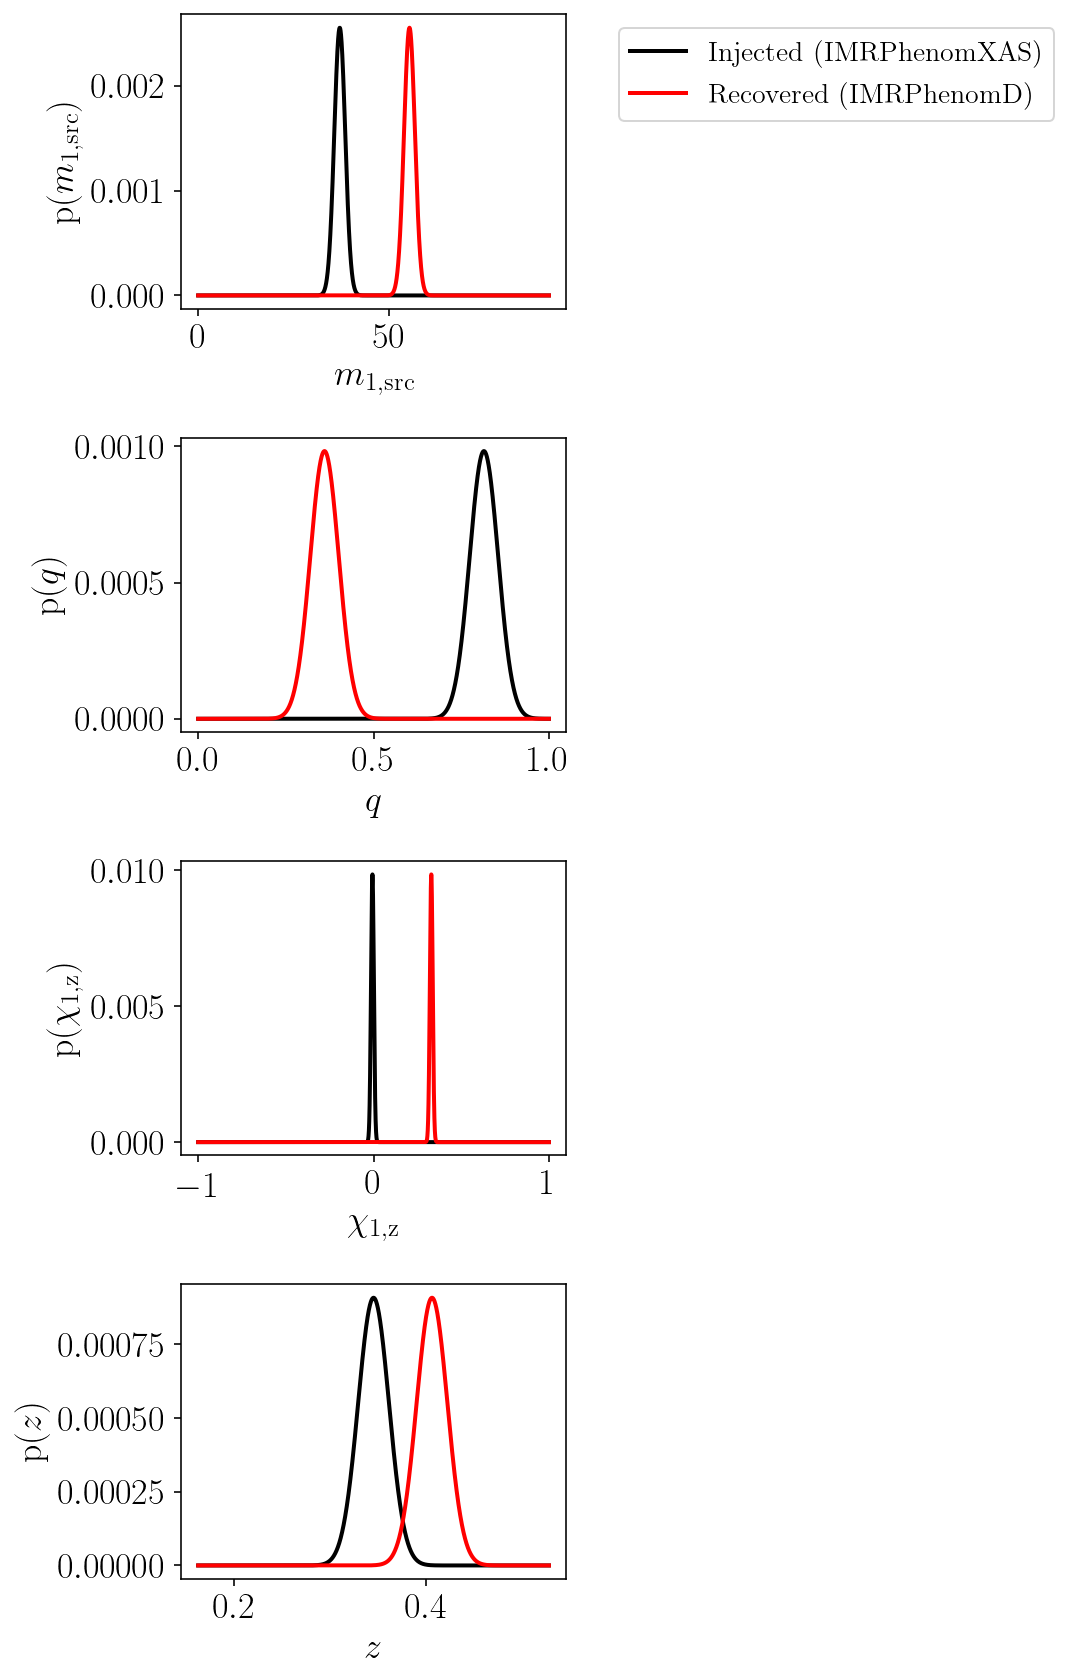

In [ ]:
index = 54837
print(df[(df["index"]==index) & (df["hybr"]==0.0)].transpose().to_string())
# print("SNR: ", df[(df["index"]==index) & (df["hybr"]==0.0)]["snr"].values)


vars=['m1_src', 'q', 'chi1z', 'z']
# vars=['m1_src', 'm2_src', 'chi1z', 'z', 'DL', 'ra', 'dec', 'iota']
plot_bias(index=index, vars=vars ,labels=labels, hybr=0.0)#, hybr_2 = 0.96)

### Bias is above mass gap: 16687

In [ ]:
mask = (df["hybr"]==0.0) * (np.abs(df["m1_src"]+df["m1_src_bias"])>70) * (np.abs(df["m1_src"])<50) * (np.abs(df["m1_src_bias"]/df["m1_src_err"])>2) * (df["z"] + df["z_bias"] > 0.2)
df[mask]

/opt/anaconda3/envs/gwbench/lib/python3.7/site-packages/pandas/core/computation/expressions.py:215: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


,index,Mc,eta,chi1x,chi2x,chi1y,chi2y,chi1z,chi2z,DL,...,m2_src_bias,m1_det,m2_det,m1_det_err,m2_det_err,m1_det_bias,m2_det_bias,q,q_err,q_bias
12495,12498,139.599493,0.246647,0.0,0.0,0.0,0.0,0.088386,0.300909,75064.779317,...,95.952645,180.383083,142.940922,31.796561,13.734790,30.299920,67.742081,0.792430,0.075628,0.207570
10862,50887,516.564316,0.246475,0.0,0.0,0.0,0.0,-0.025474,0.058153,192607.803868,...,228.418246,669.521341,527.387650,93.412520,26.826665,2784.705660,2926.839351,0.787708,0.038762,0.212292
2464,82527,58.712408,0.249977,0.0,0.0,0.0,0.0,-0.109189,-0.046038,14647.436148,...,17.854456,68.090426,66.802645,6.754384,15.790701,27.209597,-15.418342,0.981087,0.213261,-0.441903
16405,96470,100.612541,0.245537,0.0,0.0,0.0,0.0,-0.061399,0.166981,26750.245340,...,52.205490,132.439839,101.219067,14.197997,21.044578,23.752982,8.767989,0.764265,0.158257,-0.060090


                    16681
index        16687.000000
Mc              36.849034
eta              0.229602
chi1x            0.000000
chi2x            0.000000
chi1y            0.000000
chi2y            0.000000
chi1z           -0.072860
chi2z            0.191772
DL             542.914565
tc               0.000000
phic             0.000000
iota             0.260200
ra               4.159247
dec              0.715388
psi              0.457920
gmst0            0.000000
hybr             0.000000
Mc_err           0.000613
eta_err          0.000178
DL_err          22.614975
chi1z_err        0.001448
chi2z_err        0.000512
iota_err         0.157548
ra_err           0.000206
dec_err          0.000093
psi_err          0.001860
Mc_bias          0.214123
eta_bias        -0.007861
DL_bias       -852.090163
chi1z_bias       0.131077
chi2z_bias      -0.027592
iota_bias       12.665443
ra_bias         -0.003489
dec_bias         0.002870
psi_bias         0.023268
snr           3191.403933
faith       

/opt/anaconda3/envs/gwbench/lib/python3.7/site-packages/pandas/core/computation/expressions.py:215: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


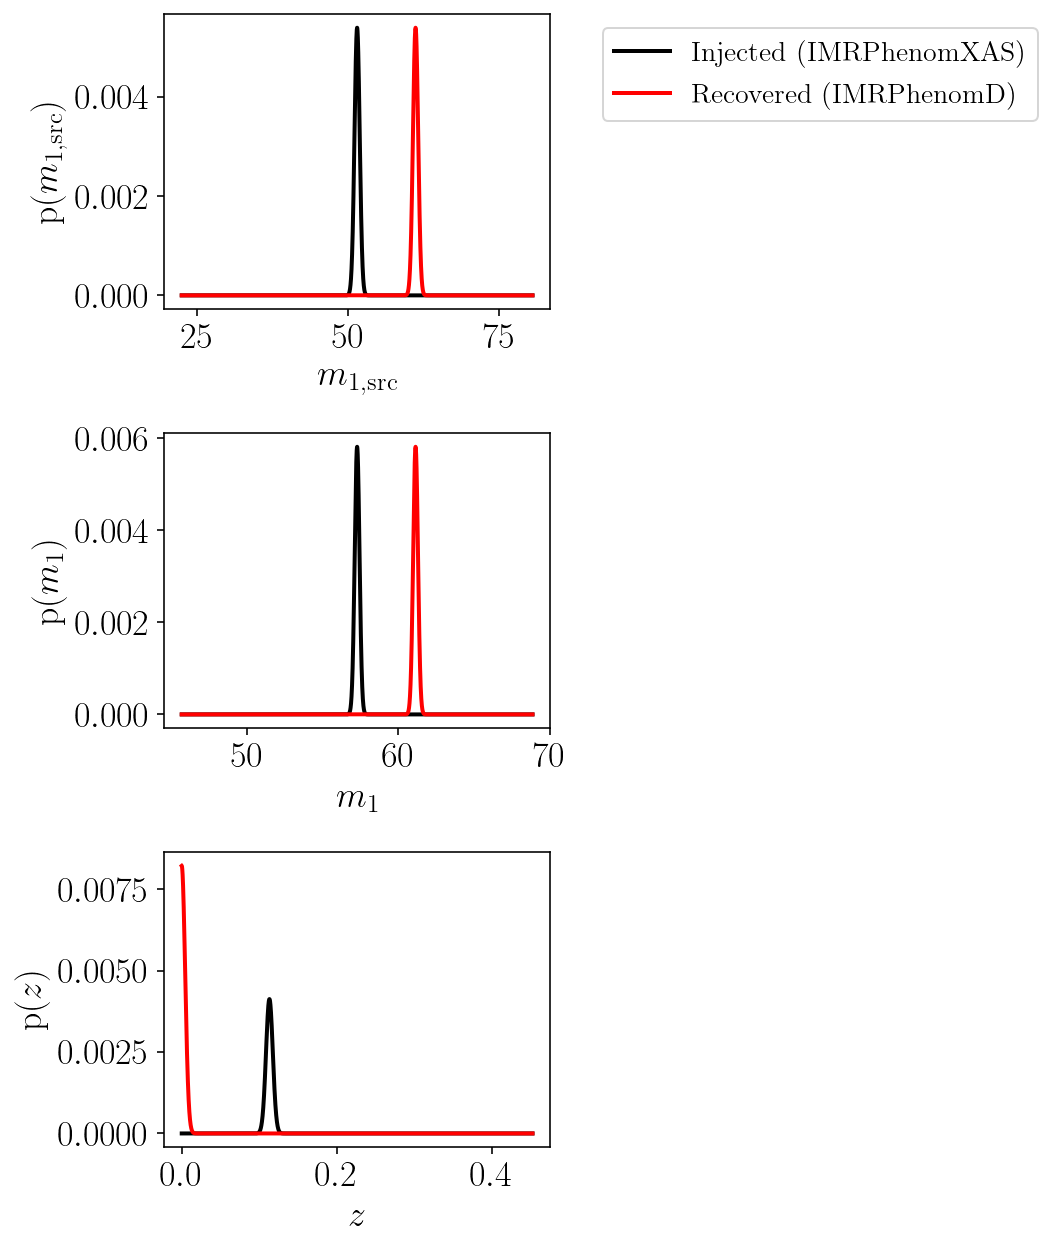

In [ ]:
index = 16687
# index = 2241	

print(df[(df["index"]==index) & (df["hybr"]==0.0)].transpose().to_string())
# print("SNR: ", df[(df["index"]==index) * (df["hybr"]==0.0)]["snr"].values)
df_index = df[(df["index"]==index)* (df["hybr"]==0.0)]
m1 = ((df_index["m1_src"]))
bias = ((df_index["m1_src_bias"]))
err = ((df_index["m1_src_err"]))
print(m1)
print(m1+bias)
print(bias/err)

vars=['m1_src', 'm1_det', 'z']
# # vars=['m1_src', 'm2_src', 'chi1z', 'z', 'DL', 'ra', 'dec', 'iota']
plot_bias(index=index, vars=vars ,labels=labels, hybr=0.0)


                    16681
index        16687.000000
Mc              36.849034
eta              0.229602
chi1x            0.000000
chi2x            0.000000
chi1y            0.000000
chi2y            0.000000
chi1z           -0.072860
chi2z            0.191772
DL             542.914565
tc               0.000000
phic             0.000000
iota             0.260200
ra               4.159247
dec              0.715388
psi              0.457920
gmst0            0.000000
hybr             0.000000
Mc_err           0.000613
eta_err          0.000178
DL_err          22.614975
chi1z_err        0.001448
chi2z_err        0.000512
iota_err         0.157548
ra_err           0.000206
dec_err          0.000093
psi_err          0.001860
Mc_bias          0.214123
eta_bias        -0.007861
DL_bias       -852.090163
chi1z_bias       0.131077
chi2z_bias      -0.027592
iota_bias       12.665443
ra_bias         -0.003489
dec_bias         0.002870
psi_bias         0.023268
snr           3191.403933
faith       

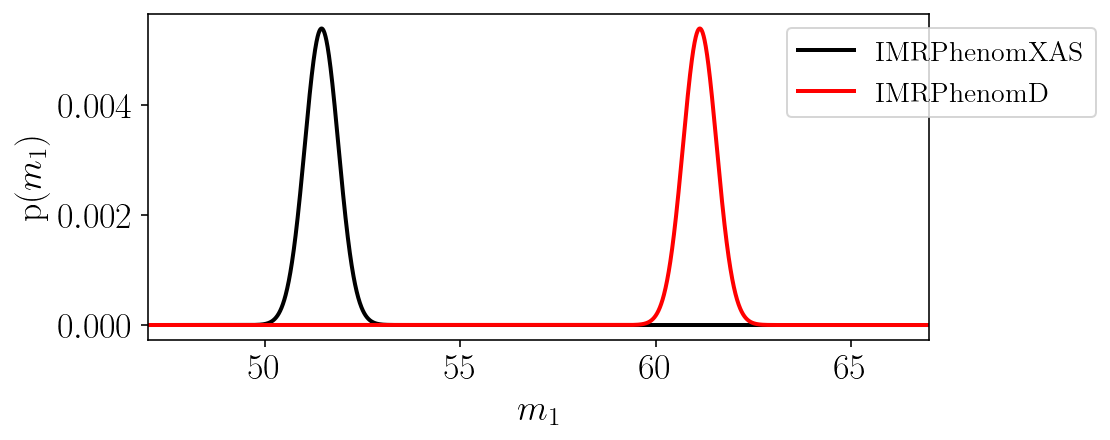

In [ ]:
index = 16687
print(df[(df["index"]==index) & (df["hybr"]==0.0)].transpose().to_string())

df_index = df[(df["index"]==index) & (df["hybr"]==0.0)]
mu = ((df_index["m1_src"]))
bias = ((df_index["m1_src_bias"]))
sigma = ((df_index["m1_src_err"]))

print(mu)
print(mu+bias)

fig, ax = plt.subplots(figsize=(7, 3))

x = np.linspace(mu-3*bias, mu+3*bias, 10000)
inj_est = stats.norm.pdf(x, mu, sigma)
inj_est = inj_est/np.sum(inj_est)

biased_est = stats.norm.pdf(x, mu+bias, sigma)
biased_est = biased_est/ np.sum(biased_est)

inj_est[x<0] = 0
biased_est[x<0] = 0

plt.plot(x, inj_est, label=f"IMRPhenomXAS", color='k', lw=2)
plt.plot(x, biased_est, label=f"IMRPhenomD",color='r', lw=2)

plt.xlim(47, 67)

plt.xlabel("$m_1$")
plt.ylabel("p$(m_1)$")

plt.legend(bbox_to_anchor=(0.8, 1), fontsize=14)

plt.show()

### Large, misaligned Spins ($m_1 \sim 6.5 M_\odot$, $q \sim 0.75$, $\chi_{1,z} \sim -0.6$, $\chi_{2,z} \sim 0.2$, z $\sim 0.2$ , SNR $\sim 170$): 88308

In [ ]:
mask = (df["hybr"]==0.0) * ((df["chi1z"]/df["chi2z"]) < 0) * (np.abs(df["chi1z"]) > 0.5) * (df["snr"] > 100)
df[mask]

/var/folders/wj/l7fs8hg555n8nzz7myk9cysw0000gn/T/ipykernel_22737/1756106242.py:1: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead.
  mask = (df["hybr"]==0.0) * ((df["chi1z"]/df["chi2z"]) < 0) * (np.abs(df["chi1z"]) > 0.5) * (df["snr"] > 100)


,index,Mc,eta,chi1x,chi2x,chi1y,chi2y,chi1z,chi2z,DL,...,m1_det_err,m2_det_err,m1_det_bias,m2_det_bias,q,q_err,q_bias,chi_eff,chi_eff_bias,chi_eff_err
10262,10265,3.861517,0.241520,0.0,0.0,0.0,0.0,-0.530622,0.012536,130.905634,...,0.030119,0.018843,0.808087,-0.439993,0.688944,0.007272,-0.161526,-0.309061,0.125022,0.005247
6566,26573,8.686779,0.206617,0.0,0.0,0.0,0.0,-0.552783,0.025244,982.429409,...,0.118668,0.351626,-0.513976,0.183983,0.411858,0.022726,0.025804,-0.384165,-0.024742,0.011758
1746,81809,6.796047,0.249965,0.0,0.0,0.0,0.0,0.540684,-0.091326,3069.890885,...,0.372579,1.729585,-0.092312,0.093088,0.976532,0.213076,0.023468,0.228431,-0.228431,3.077965
8244,88308,5.802907,0.245082,0.0,0.0,0.0,0.0,-0.630675,0.241278,1021.606335,...,0.415981,0.252855,1.116797,-0.679965,0.753999,0.067329,-0.172789,-0.255845,0.185550,0.082695
18269,98334,6.604596,0.249999,0.0,0.0,0.0,0.0,0.559473,-0.004161,454.593236,...,0.018583,0.018290,0.100694,-0.096632,0.996116,0.004351,-0.025569,0.278204,0.318159,0.666208


                     8244
index        88308.000000
Mc               5.802907
eta              0.245082
chi1x            0.000000
chi2x            0.000000
chi1y            0.000000
chi2y            0.000000
chi1z           -0.630675
chi2z            0.241278
DL            1021.606335
tc               0.000000
phic             0.000000
iota             2.070495
ra               2.433430
dec              0.084046
psi              4.114547
gmst0            0.000000
hybr             0.000000
Mc_err           0.000145
eta_err          0.001871
DL_err          21.444650
chi1z_err        0.113106
chi2z_err        0.114624
iota_err         0.025626
ra_err           0.011444
dec_err          0.010570
psi_err          0.031556
Mc_bias          0.000856
eta_bias        -0.012619
DL_bias       1574.092490
chi1z_bias       1.012735
chi2z_bias      -1.089872
iota_bias       -0.042498
ra_bias         -0.065124
dec_bias        -0.059412
psi_bias         0.268199
snr            168.752204
faith       

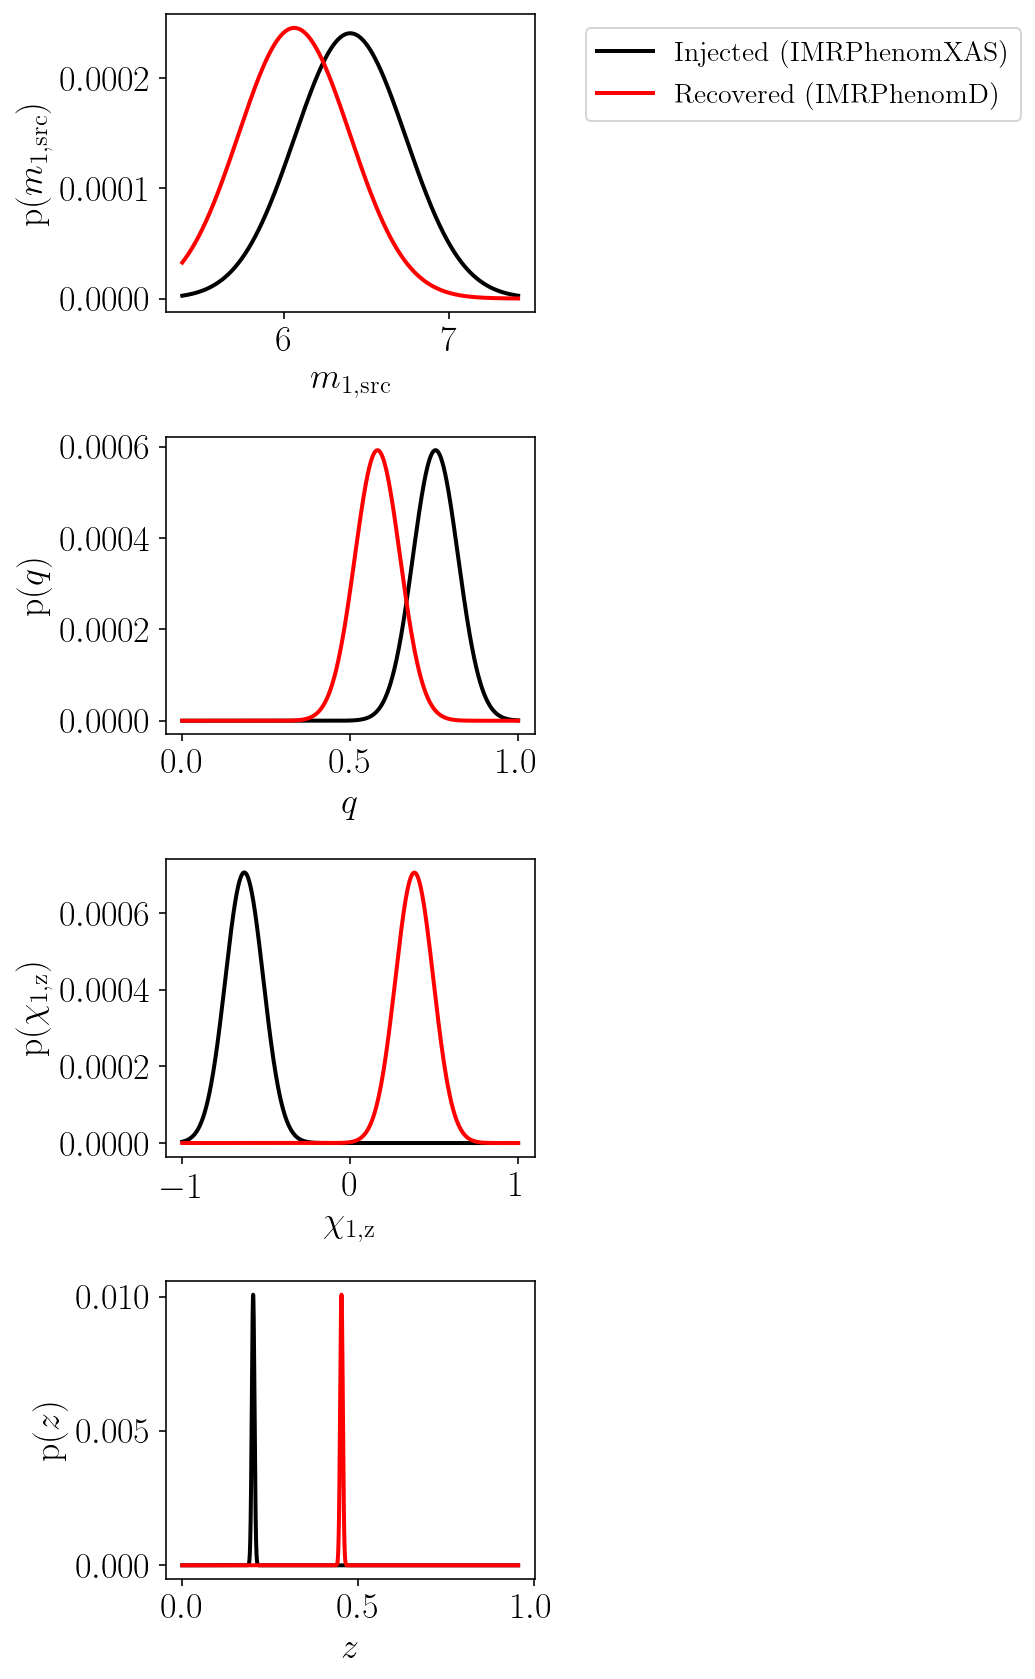

In [ ]:
index = 88308
print(df[(df["index"]==index) & (df["hybr"]==0.0)].transpose().to_string())
# print("SNR: ", df[(df["index"]==index) * (df["hybr"]==0.0)]["snr"].values)

vars=['m1_src', 'q', 'chi1z', 'z']
# vars=['m1_src', 'm2_src', 'chi1z', 'z', 'DL', 'ra', 'dec', 'iota']
plot_bias(index=index, vars=vars ,labels=labels, hybr=0.0)

In [ ]:
mask = (df["hybr"]==0.0) * (np.abs(df["m1_src"])>40) * (np.abs(df["m2_src"])>40) * (df["z"] < 1.0)
df[mask]

/opt/anaconda3/envs/gwbench/lib/python3.7/site-packages/pandas/core/computation/expressions.py:215: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


,index,Mc,eta,chi1x,chi2x,chi1y,chi2y,chi1z,chi2z,DL,...,m2_src_bias,m1_det,m2_det,m1_det_err,m2_det_err,m1_det_bias,m2_det_bias,q,q_err,q_bias
4528,4530,77.866412,0.246395,0.0,0.0,0.0,0.0,0.066716,0.088726,6194.468899,...,-17.219952,101.062209,79.393517,4.786664,2.155953,26.957343,-9.107594,0.785591,0.039774,-0.236566
9759,69819,68.503066,0.247566,0.0,0.0,0.0,0.0,-0.004625,0.000305,4551.510201,...,-18.572697,86.962568,71.342682,4.358320,2.076446,30.976485,-13.056387,0.820384,0.047899,-0.326177
12758,72819,76.385828,0.249495,0.0,0.0,0.0,0.0,0.077219,-0.199096,3802.796745,...,-12.496181,91.797482,83.903929,6.738607,3.450665,0.212609,8.106162,0.914011,0.072991,0.085989
19108,79170,47.527595,0.248222,0.0,0.0,0.0,0.0,0.229195,0.152711,1108.390612,...,-4.738782,59.452667,50.205604,1.682238,1.147249,-4.071355,5.175708,0.844463,0.038705,0.155537


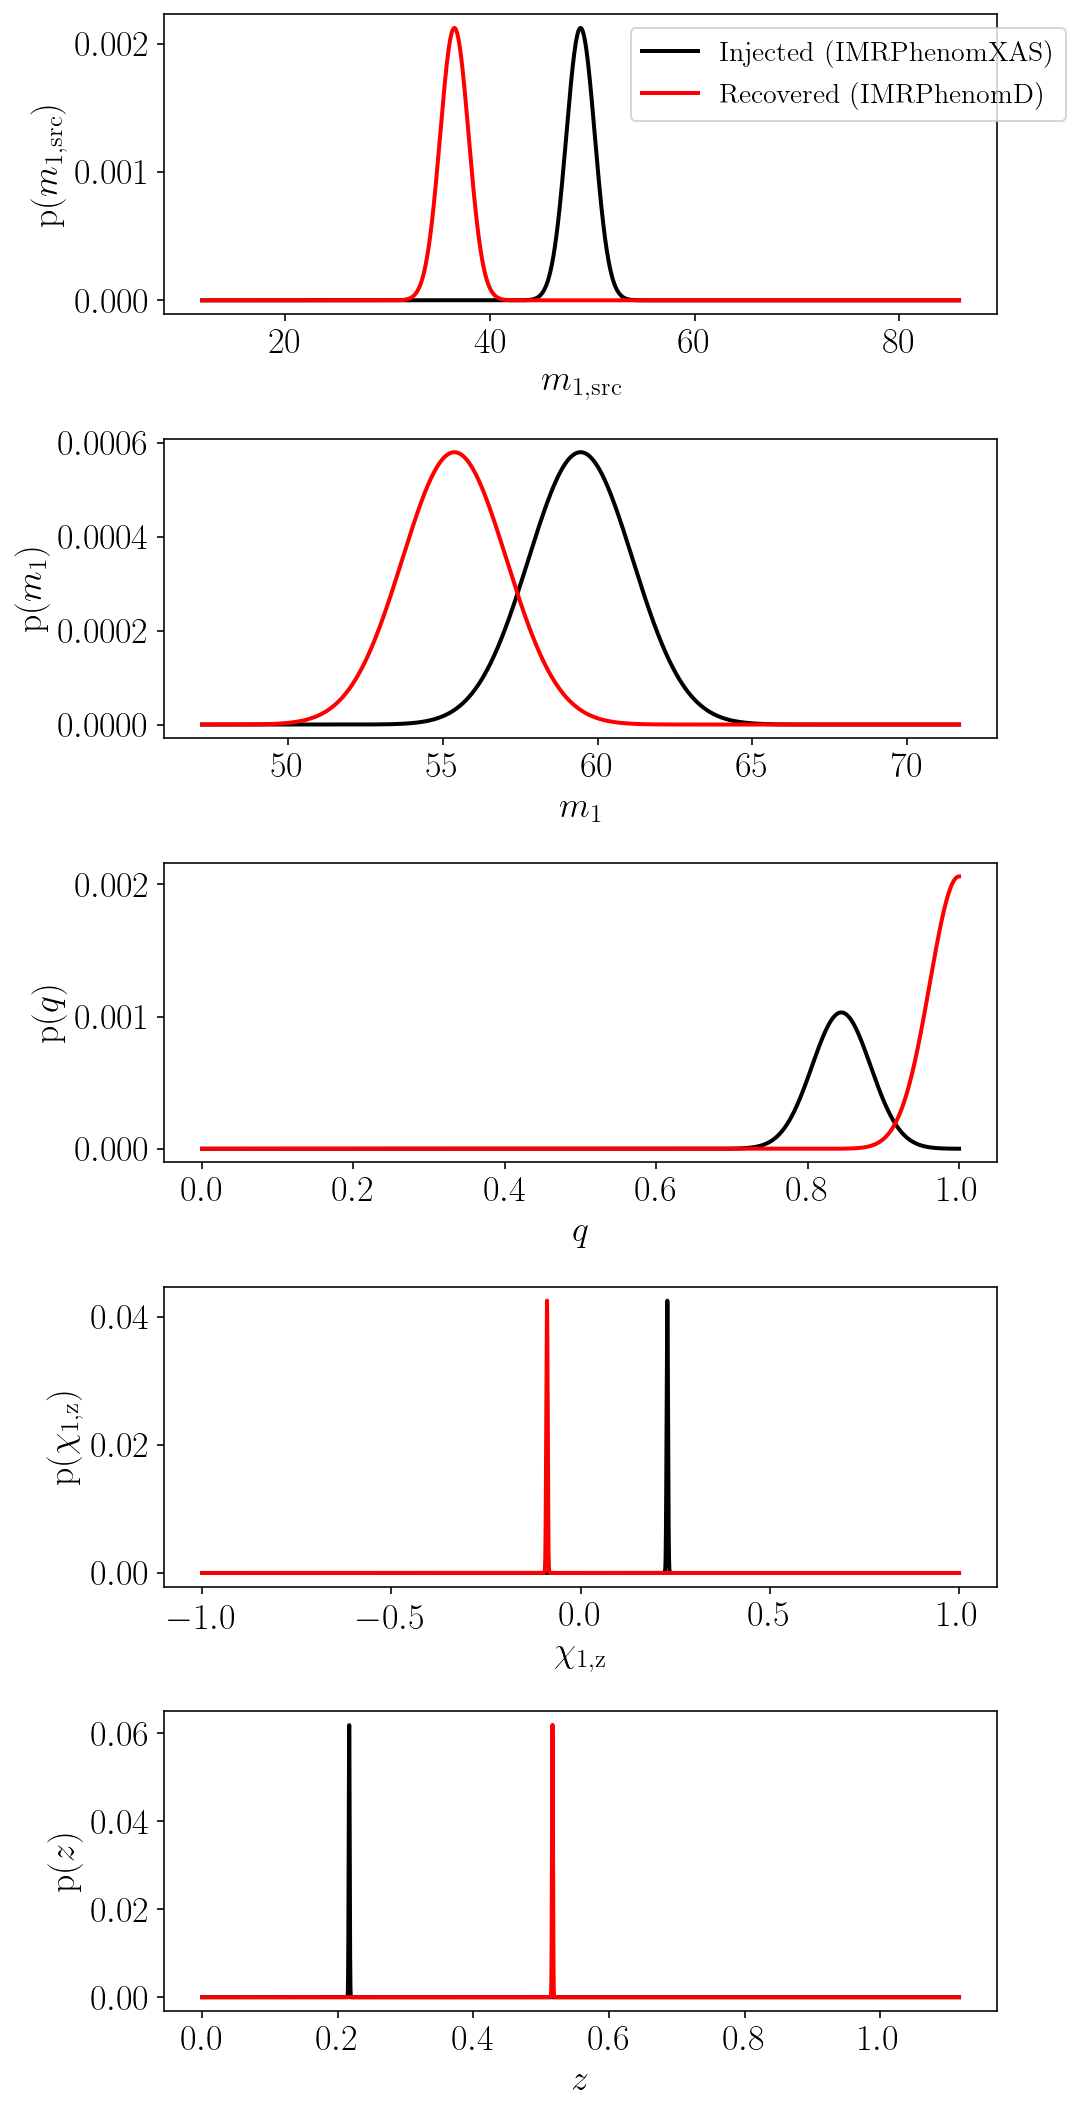

In [ ]:
index = 79170
# print(df[(df["index"]==index) * (df["hybr"]==0.0)].transpose().to_string())
# print("SNR: ", df[(df["index"]==index) * (df["hybr"]==0.0)]["snr"].values)

vars=['m1_src', 'm1_det', 'q', 'chi1z', 'z']
# vars=['m1_src', 'm2_src', 'chi1z', 'z', 'DL', 'ra', 'dec', 'iota']
plot_bias(index=index, vars=vars ,labels=labels, hybr=0.0)

# q-chieff correlation test

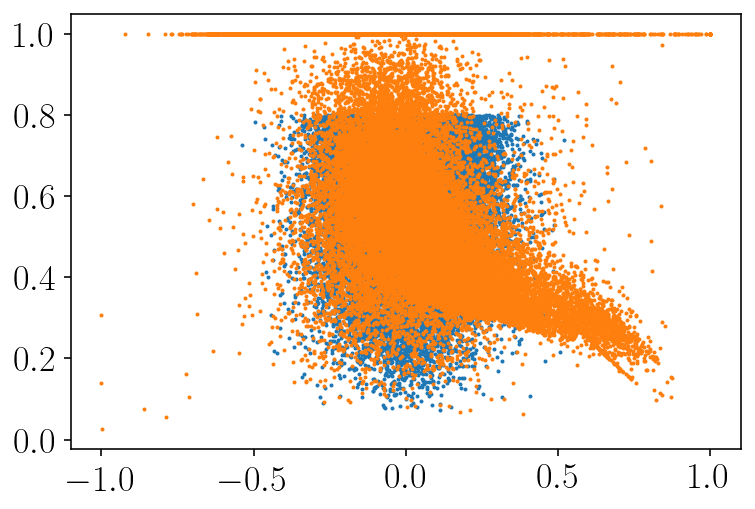

In [ ]:
data = df[(df["hybr"]==0.0) & (df["snr"]>10) & (df["q"]<0.8)]
plt.scatter(data["chi_eff"], data["q"], s=1)

plt.scatter(data["chi_eff"]+data["chi_eff_bias"], data["q"]+data["q_bias"], s=1)
plt.show()

(0.0, 400000.0)

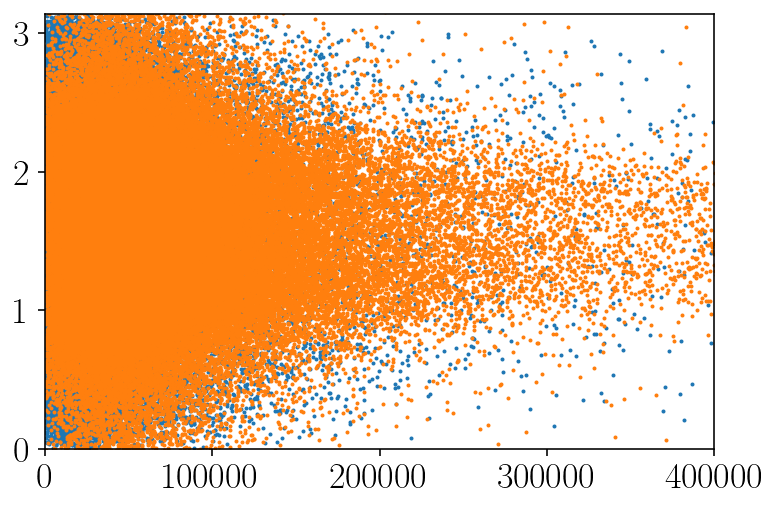

In [ ]:
data = df[df["hybr"]==0.0]
plt.scatter(data["DL"], data["iota"], s=1)

plt.scatter(data["DL"]+data["DL_bias"], data["iota"]+data["iota_bias"], s=1)

plt.ylim(0, np.pi)
plt.xlim(0, 400000)